# Resource usage - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_sample", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from data.gas_cost import compute_component_gas_costs_per_tx
from resource_gas_split import compute_resource_gas_cost_per_tx

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for the sampled blocks.

In [5]:
block_start = 22000000
block_end = 22300000
# Load parquet files with duckdb
query = f"""
SELECT *
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Clean up repeated opcodes
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("DUP"), "DUP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("SWAP"), "SWAP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    (agg_trace_df["op"].str.startswith("PUSH")) & (agg_trace_df["op"] != "PUSH0"),
    "PUSH",
    agg_trace_df["op"],
)
# Compute total gas cost for opcode
agg_trace_df["op_total_gas_cost"] = (
    agg_trace_df["op_gas_cost"] * agg_trace_df["op_gas_pair_count"]
)
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90312290 entries, 0 to 90312289
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tx_hash            object 
 1   op                 object 
 2   op_gas_cost        float64
 3   post_memory_size   float64
 4   memory_expansion   float64
 5   memory_size        float64
 6   cum_refund         int64  
 7   call_address       object 
 8   op_gas_pair_count  int64  
 9   block_height       int64  
 10  op_total_gas_cost  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 7.4+ GB


In [6]:
agg_trace_df["block_height"].agg(["min", "max"])

min    22000017
max    22299951
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [7]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_sample.parquet")
)
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994992 entries, 0 to 994991
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            994992 non-null  int64 
 1   tx_hash                 994992 non-null  object
 2   tx_gas_cost             994992 non-null  int64 
 3   tx_gas_limit            994992 non-null  int64 
 4   tx_input_zero_bytes     994992 non-null  int64 
 5   tx_input_nonzero_bytes  994992 non-null  int64 
 6   tx_input_data_cost      994992 non-null  int64 
 7   is_contract_creation    994992 non-null  bool  
 8   is_success              994992 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 55.0+ MB


## 3. Process data

In [8]:
# Compute gas costs by component
comp_df = compute_component_gas_costs_per_tx(agg_trace_df, tx_gas_info_df)
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994992 entries, 0 to 994991
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           994992 non-null  int64  
 1   tx_hash                994992 non-null  object 
 2   total_gas_cost         994992 non-null  int64  
 3   input_data_cost        994992 non-null  int64  
 4   intrinsic_base_cost    994992 non-null  float64
 5   op_gas_cost            994992 non-null  float64
 6   gas_refund             994992 non-null  float64
 7   intrinsic_access_cost  994992 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 60.7+ MB


In [9]:
# How many transactions with strange intrinsic access costs?
strange_access_txs = comp_df[~comp_df["intrinsic_access_cost"].between(0, 4000000)][
    "tx_hash"
].values.tolist()
gas_perc = (
    comp_df[comp_df["tx_hash"].isin(strange_access_txs)]["total_gas_cost"].sum()
) / (comp_df["total_gas_cost"].sum())

print("tx %:", np.round(100 * len(strange_access_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 0.71
gas %: 1.16


In [10]:
# How many failed transactions?
fail_txs = tx_gas_info_df[~tx_gas_info_df["is_success"]]["tx_hash"].values.tolist()
gas_perc = (comp_df[comp_df["tx_hash"].isin(fail_txs)]["total_gas_cost"].sum()) / (
    comp_df["total_gas_cost"].sum()
)

print("tx %:", np.round(100 * len(fail_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 2.81
gas %: 3.03


In [11]:
# Compute gas cost by resource
# fail_txs and strange_access_txs are unassigned...
ignore_txs = fail_txs + strange_access_txs
gas_by_resource_df = compute_resource_gas_cost_per_tx(
    agg_trace_df,
    tx_gas_info_df,
    comp_df,
    ignore_txs,
)
gas_by_resource_df.head()

,tx_hash,Compute,Access,Memory,History,Bloom topics,State,Bandwidth,Unassigned,block_height,State (exc. Refunds)
0,0x00001cc75d686d99ea55a96f33f32c472ca37e438a62...,11653.0,14300.0,12.0,7646.0,750.0,22700.0,6148.0,0.0,22181639.0,22700.0
1,0x00001e6840a05a7cceb313425d9cee604ad011758a18...,18890.0,10800.0,136.0,10207.5,250.0,19900.0,9468.5,0.0,22122690.0,19900.0
2,0x00002b10becb8aeb227de342a0efc32cb21c229b0561...,38771.0,42300.0,349.0,10916.0,2250.0,19600.0,7202.0,0.0,22161523.0,19600.0
3,0x00002db5676be40da78e0ee21e5d6f93a138f3b35772...,8500.0,300.0,0.0,6500.0,0.0,0.0,5700.0,0.0,22035811.0,0.0
4,0x00003351dfb36b8a2861a2baa96b20c778f2af85b521...,8500.0,300.0,0.0,6500.0,0.0,0.0,5700.0,0.0,22103178.0,0.0


In [12]:
# Melt (for plotting)
melt_gas_by_resource_df = gas_by_resource_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="Resource", value_name="gas_cost"
).sort_values("Resource")

melt_gas_by_resource_df.head()

,block_height,tx_hash,Resource,gas_cost
1492487,22104423.0,0x7fda2497854eca32b9d592a9d04c17d0e78b5153c300...,Access,14300.0
1326665,22018745.0,0x5542828b28f61a9cc8dc6d527c82f81809ea0278faf5...,Access,71500.0
1326664,22123204.0,0x55427482a453caf2a65946e3d95a190abb9f43c6a125...,Access,14800.0
1326663,22199605.0,0x55426d6f542de7ab95450e1a0410b561b3f5da79bbc3...,Access,6300.0
1326662,22023989.0,0x5542560c99630a52d0bee735deba3eef1a2001ffc8f8...,Access,14300.0


## 4. Analyze gas by resource

In [13]:
# Transactions with unassigned gas
total_gas = (
    gas_by_resource_df.drop(columns=["tx_hash", "block_height", "State (exc. Refunds)"])
    .sum(axis=1)
    .sum()
)
print(
    "Txs %:", 100 * sum(gas_by_resource_df["Unassigned"] > 0) / len(gas_by_resource_df)
)
print("Gas:", gas_by_resource_df["Unassigned"].sum())
print("Gas %:", 100 * gas_by_resource_df["Unassigned"].sum() / total_gas)

Txs %: 2.856907392220239
Gas: 3831304594.0
Gas %: 3.510128906758113


In [14]:
# What percentage of transactions have a positive intrinsic costs?
100 * sum(comp_df["intrinsic_access_cost"] > 0) / len(comp_df)

9.336155466576615

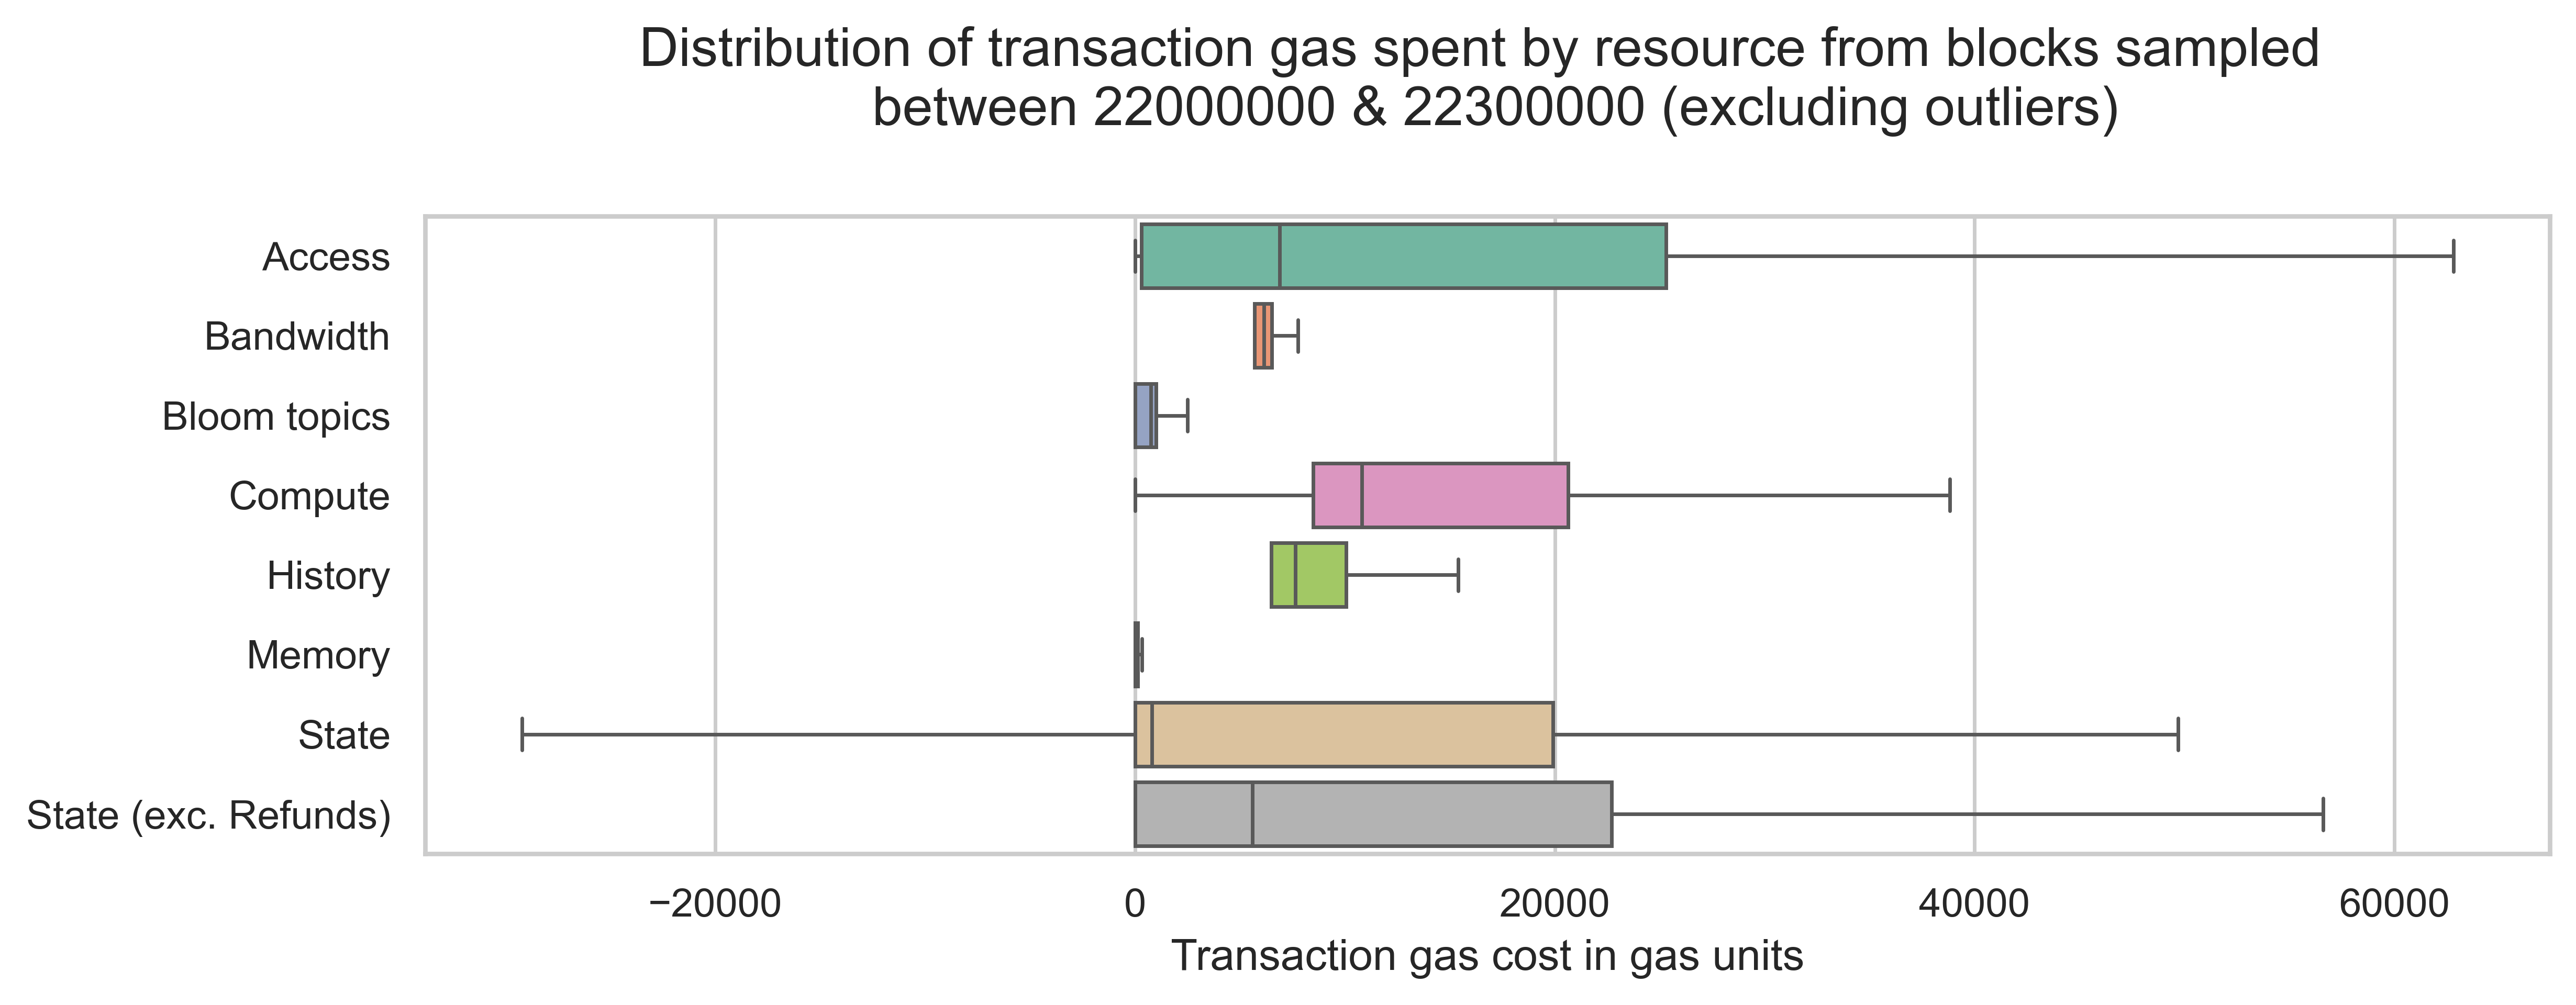

In [49]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=melt_gas_by_resource_df[melt_gas_by_resource_df["Resource"] != "Unassigned"],
    hue="Resource",
    legend=False,
    showfliers=False,
)
plt.title(
    f"Distribution of transaction gas spent by resource from blocks sampled \n between {block_start} & {block_end} (excluding outliers)",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Transaction gas cost in gas units")
plt.tight_layout()
plt.show()

In [65]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
print(temp_df.sort_values(ascending=False))
print(temp_df.sort_values(ascending=False) / temp_df.sum())

Resource
Compute         31088.531513
State           27249.588716
Access          25019.040272
History         11559.525510
Bandwidth        7899.016871
Unassigned       3831.304594
Bloom topics     2208.475750
Memory            294.485216
Name: gas_cost, dtype: float64
Resource
Compute         0.284824
State           0.249653
Access          0.229217
History         0.105905
Bandwidth       0.072368
Unassigned      0.035101
Bloom topics    0.020233
Memory          0.002698
Name: gas_cost, dtype: float64


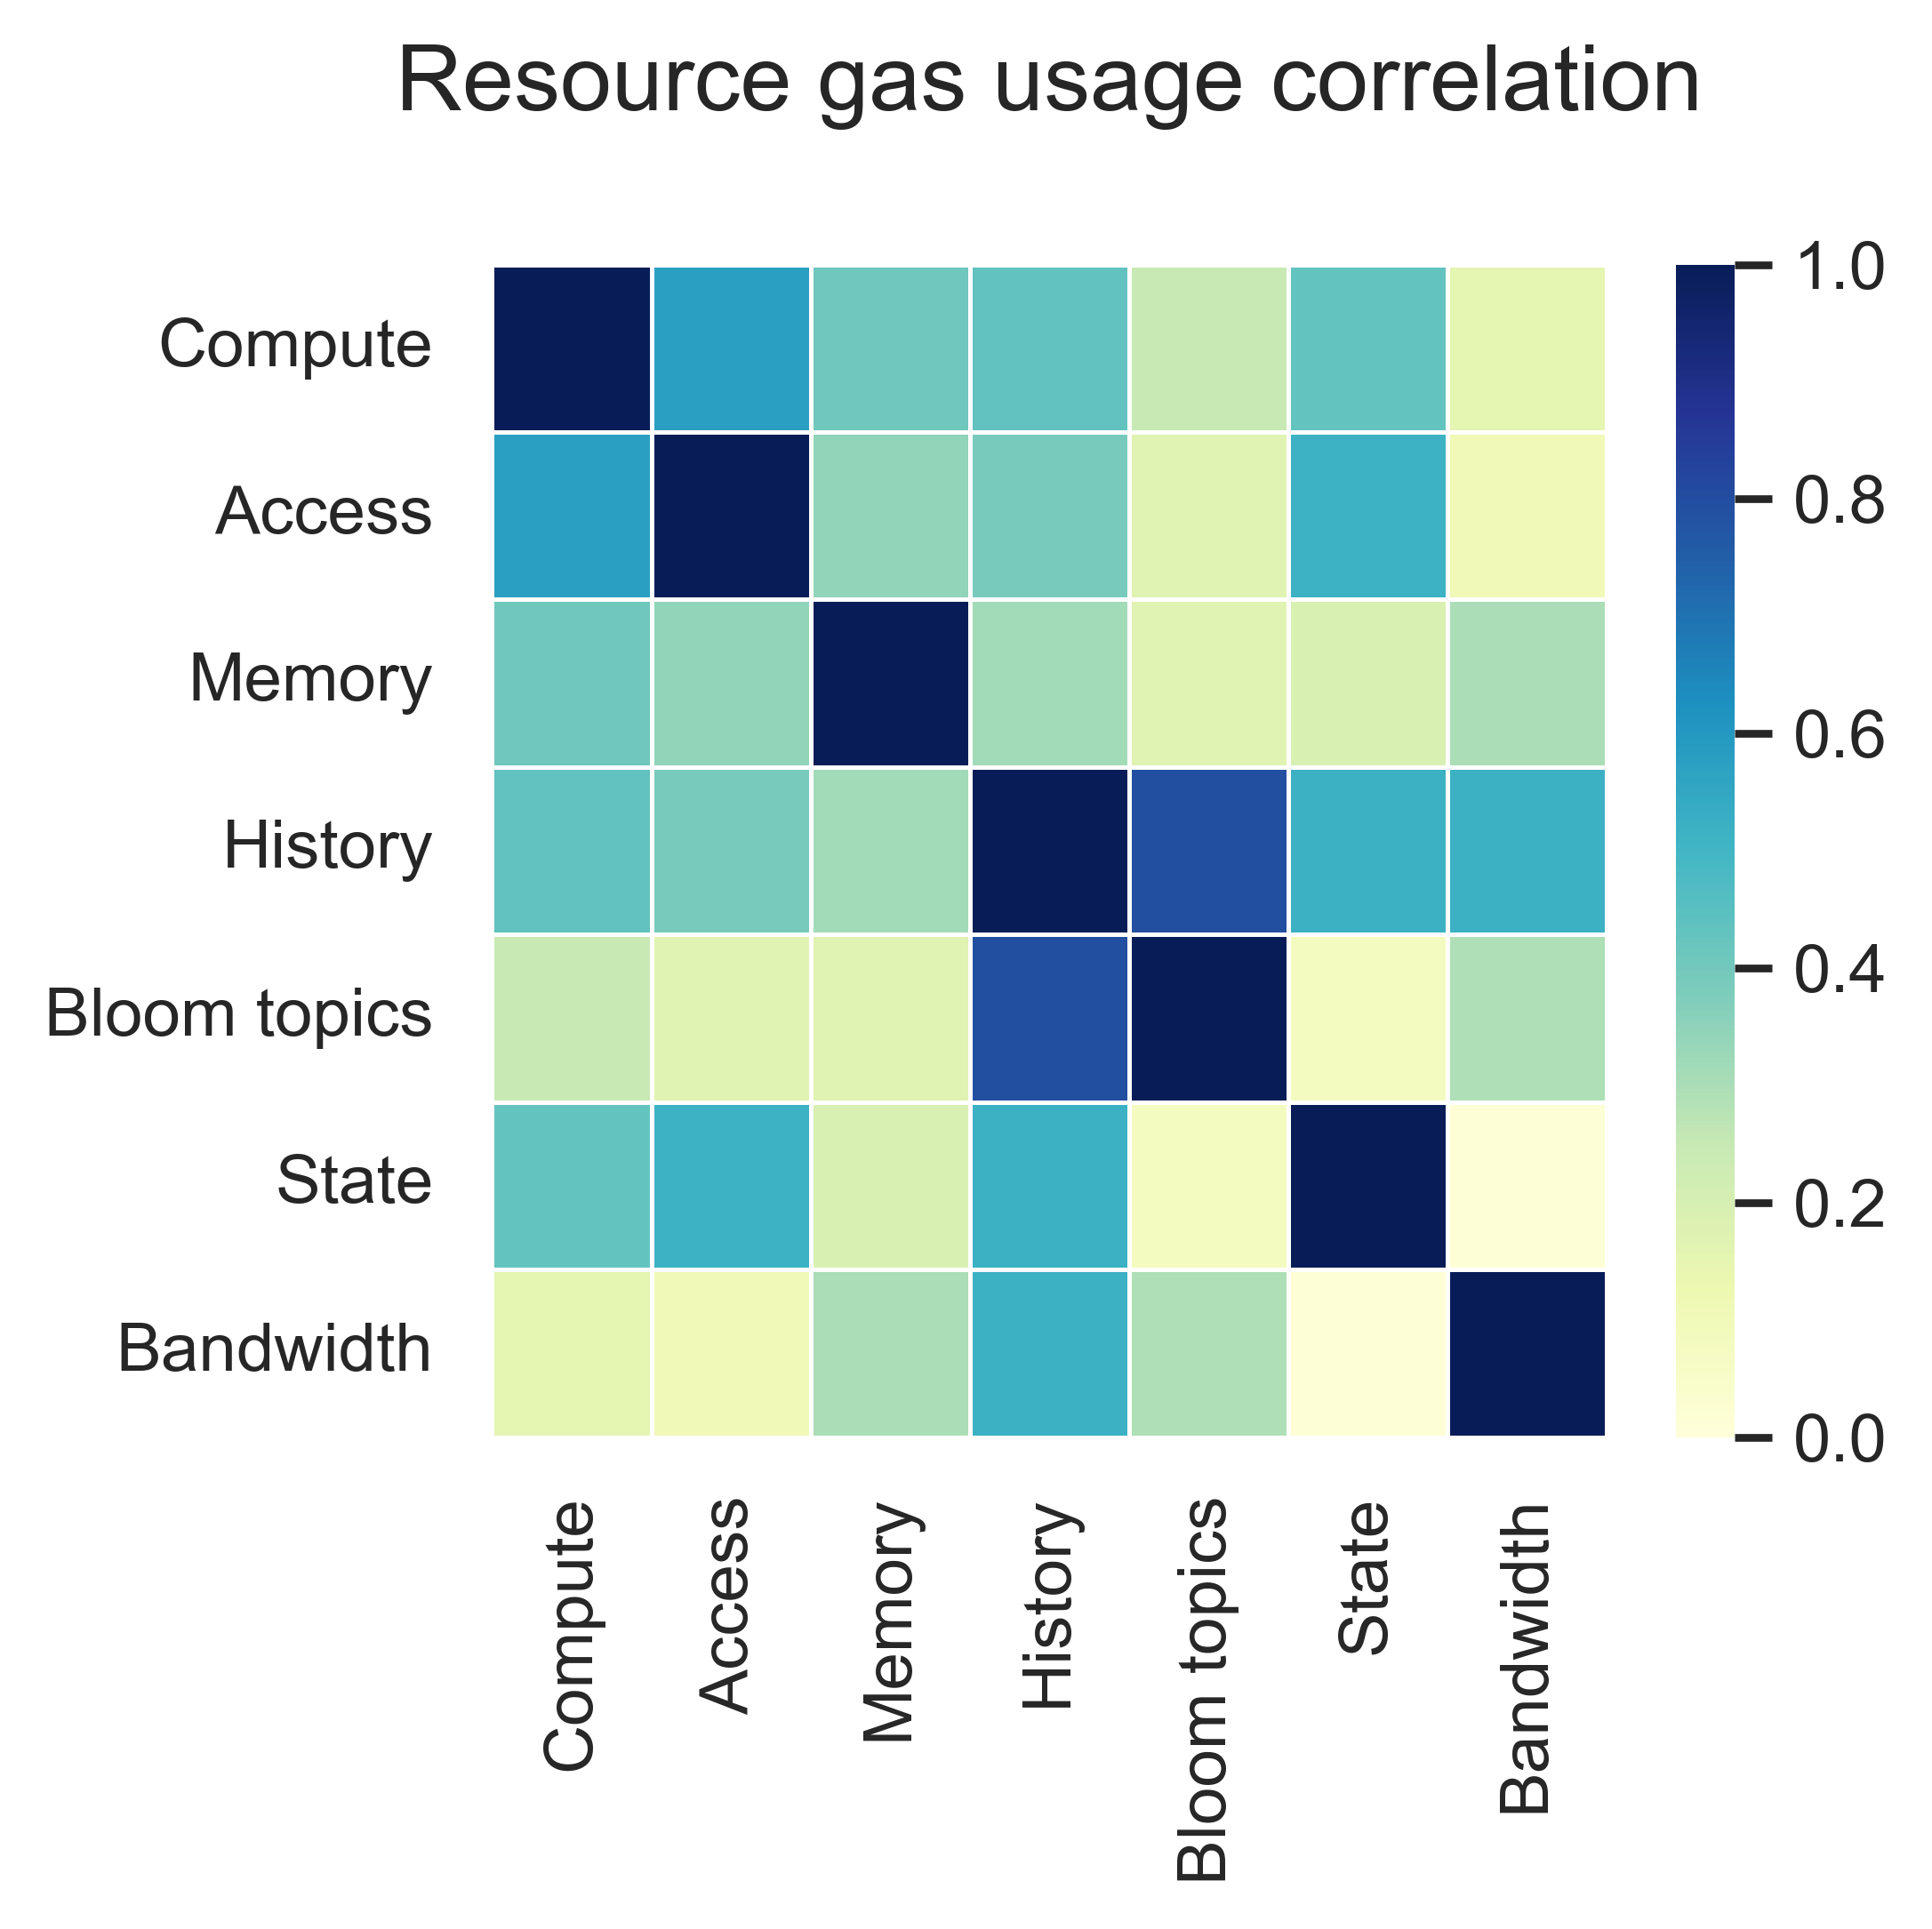

In [17]:
temp_df = gas_by_resource_df.drop(
    columns=["block_height", "Unassigned", "State (exc. Refunds)"]
).set_index("tx_hash")
corr_mat = temp_df.corr()
plt.figure(figsize=(4.5, 4.5))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, vmin=0, vmax=1)
plt.title("Resource gas usage correlation", pad=25)
plt.tight_layout()
plt.show()

## 5. Analyze block utilization

In [18]:
totals_df = (
    gas_by_resource_df.drop(columns=["tx_hash", "State (exc. Refunds)"])
    .groupby("block_height")
    .sum()
)
totals_df.head()

,Compute,Access,Memory,History,Bloom topics,State,Bandwidth,Unassigned
block_height,,,,,,,,
22000017.0,727474.0,695950.0,27237.0,727227.0,54750.0,14029680.0,1027967.0,0.0
22000092.0,5404177.0,5401244.0,47002.0,1703149.0,289500.0,2833200.0,1263037.0,0.0
22000130.0,5108354.0,4033000.0,38117.0,2207854.5,265500.0,15160200.0,1031536.5,0.0
22000174.0,7122385.0,4739195.0,342008.0,2650209.0,499500.0,2584700.0,2600182.0,0.0
22000227.0,6769234.0,5931232.0,66657.0,2213068.5,405250.0,4483066.0,1581456.5,0.0


In [19]:
# One dimensional metering
one_dim_df = totals_df.sum(axis=1).reset_index()
one_dim_df.columns = ["block_height", "usage"]
one_dim_df["perc_over_limit"] = one_dim_df["usage"] / 36_000_000
one_dim_df["utilization"] = (one_dim_df["usage"] - 18_000_000) / 18_000_000
one_dim_df["meter"] = "Unidimensional"
one_dim_df = one_dim_df.reset_index()

# Two dimensional -  State & History vs. others
two_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "others": totals_df.sum(axis=1) - totals_df["State"] - totals_df["History"],
    }
)
two_dim_df["usage"] = two_dim_df.max(axis=1)
two_dim_df["perc_over_limit"] = two_dim_df["usage"] / 36_000_000
two_dim_df["utilization"] = (two_dim_df["usage"] - 18_000_000) / 18_000_000
two_dim_df["meter"] = "State/history vs. Others"
two_dim_df = two_dim_df.reset_index()

# Two dimensional -  State & History vs. Storage Access vs. others
three_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "access": totals_df["Access"],
        "others": totals_df.sum(axis=1)
        - totals_df["State"]
        - totals_df["History"]
        - totals_df["Access"],
    }
)
three_dim_df["usage"] = three_dim_df.max(axis=1)
three_dim_df["perc_over_limit"] = three_dim_df["usage"] / 36_000_000
three_dim_df["utilization"] = (three_dim_df["usage"] - 18_000_000) / 18_000_000
three_dim_df["meter"] = "State/history vs. Access vs. Others"
three_dim_df = three_dim_df.reset_index()

# Aggregate all dataframes
util_melt_df = pd.concat(
    [
        one_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        two_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        three_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
    ],
    ignore_index=True,
)
util_melt_df.head()

,block_height,meter,usage,perc_over_limit,utilization
0,22000017.0,Unidimensional,17290285.0,0.480286,-0.039429
1,22000092.0,Unidimensional,16941309.0,0.470592,-0.058816
2,22000130.0,Unidimensional,27844562.0,0.773460,0.546920
3,22000174.0,Unidimensional,20538179.0,0.570505,0.141010
4,22000227.0,Unidimensional,21449964.0,0.595832,0.191665


In [20]:
((two_dim_df["usage"] - one_dim_df["usage"]) / one_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.305886
median   -0.297025
Name: usage, dtype: float64

In [21]:
((three_dim_df["usage"] - two_dim_df["usage"]) / two_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.31819
median   -0.36453
Name: usage, dtype: float64

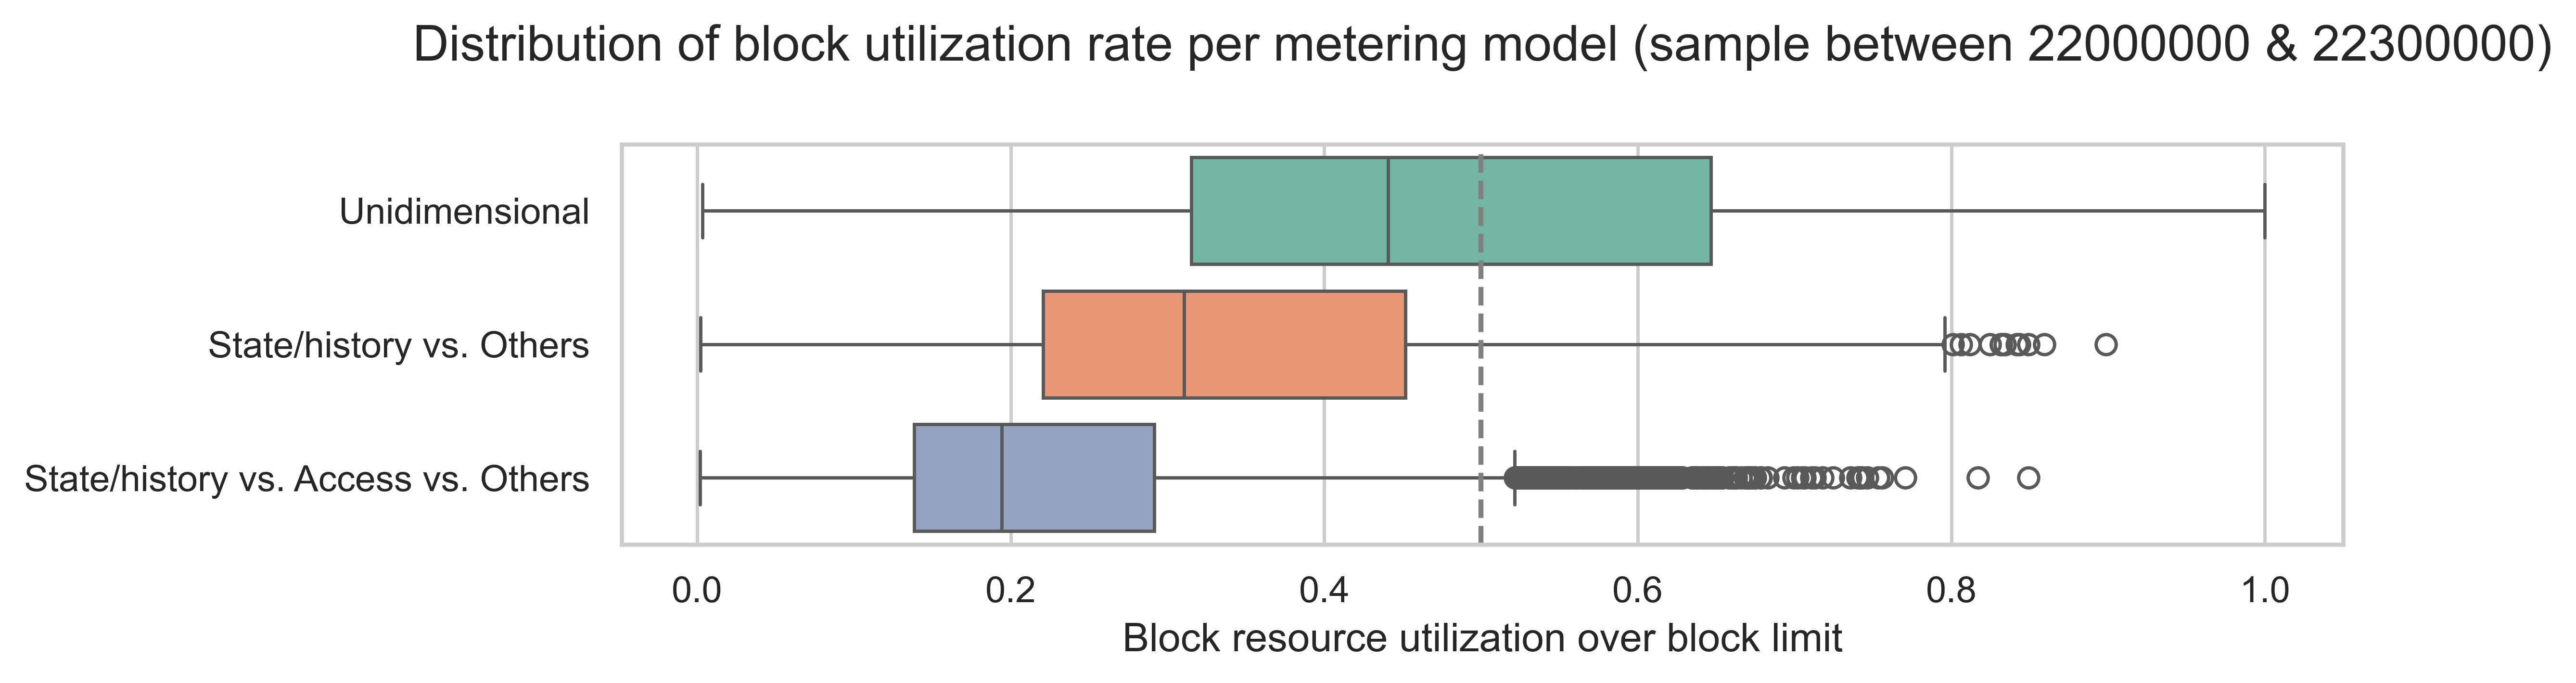

In [50]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="perc_over_limit",
    y="meter",
    hue="meter",
    legend=False,
)
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model (sample between {block_start} & {block_end})",
    pad=25,
)
plt.tight_layout()
plt.show()

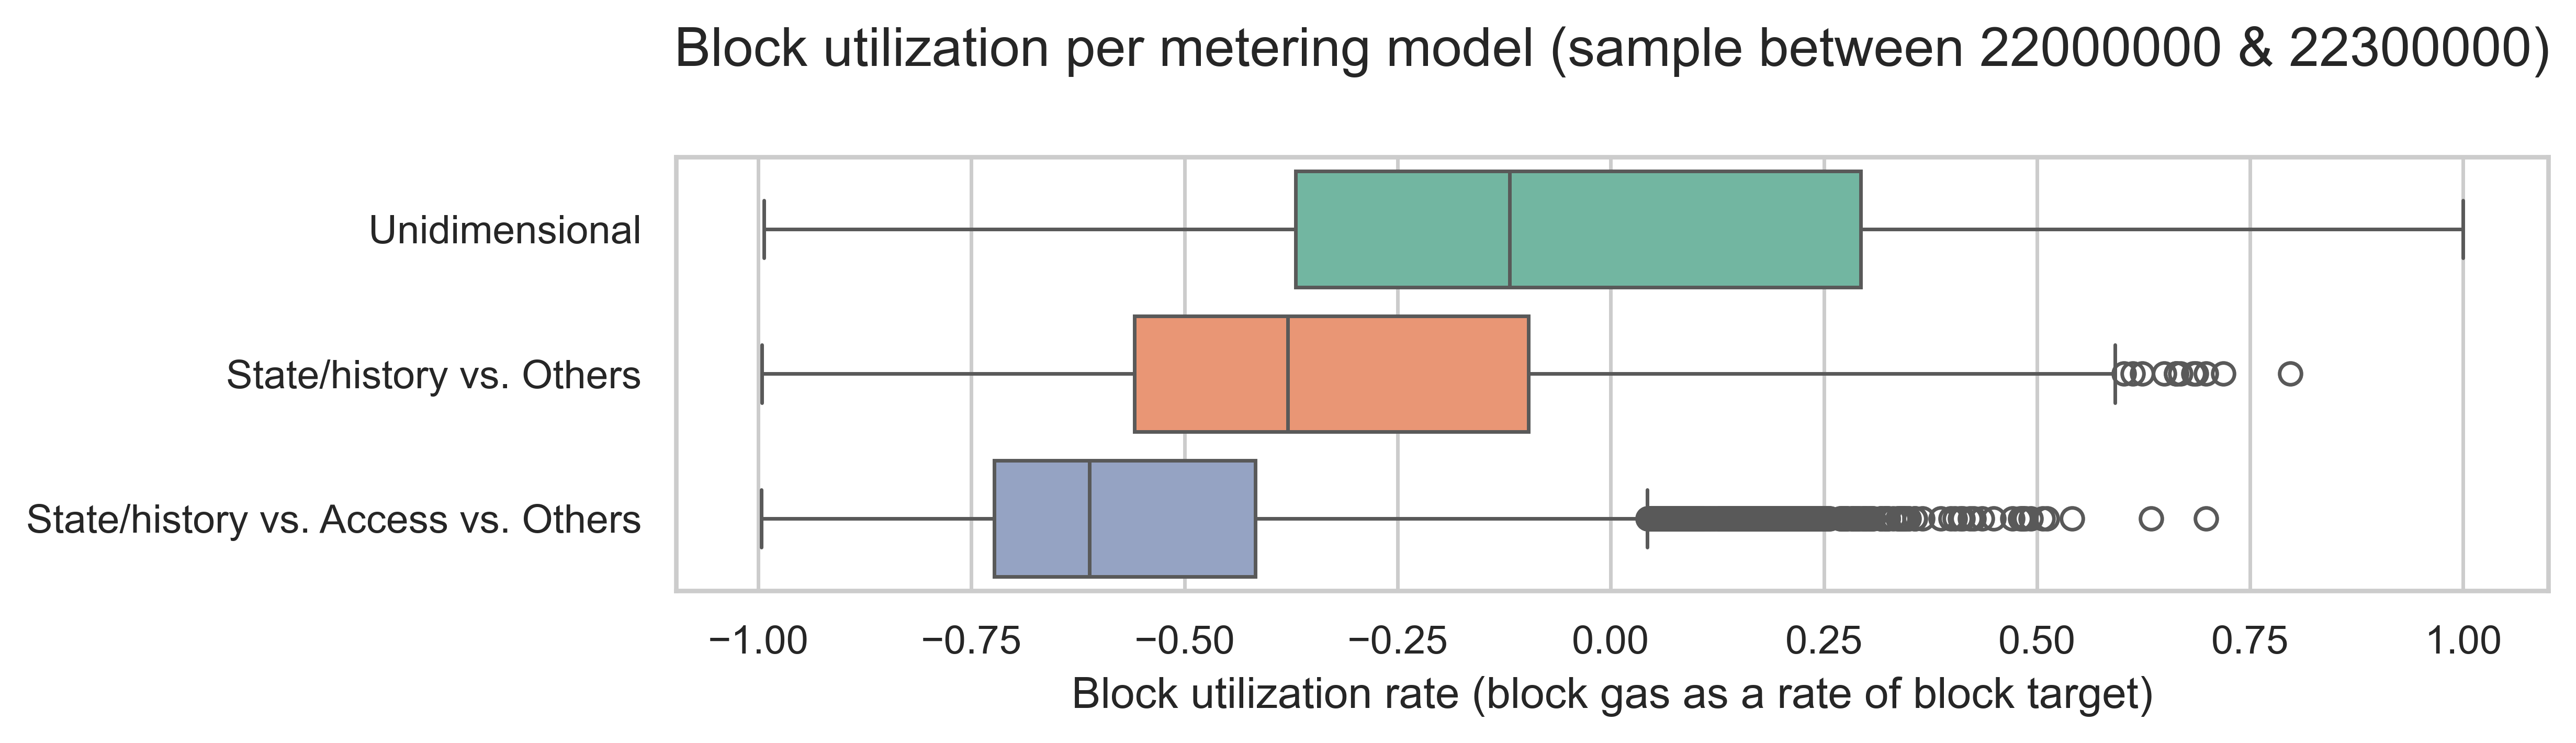

In [51]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="utilization",
    y="meter",
    hue="meter",
    legend=False,
)
plt.xlabel("Block utilization rate (block gas as a rate of block target)")
plt.ylabel("")
plt.title(f"Block utilization per metering model (sample between {block_start} & {block_end})", pad=25)
plt.tight_layout()
plt.show()

## 6. Analyze resource utilization

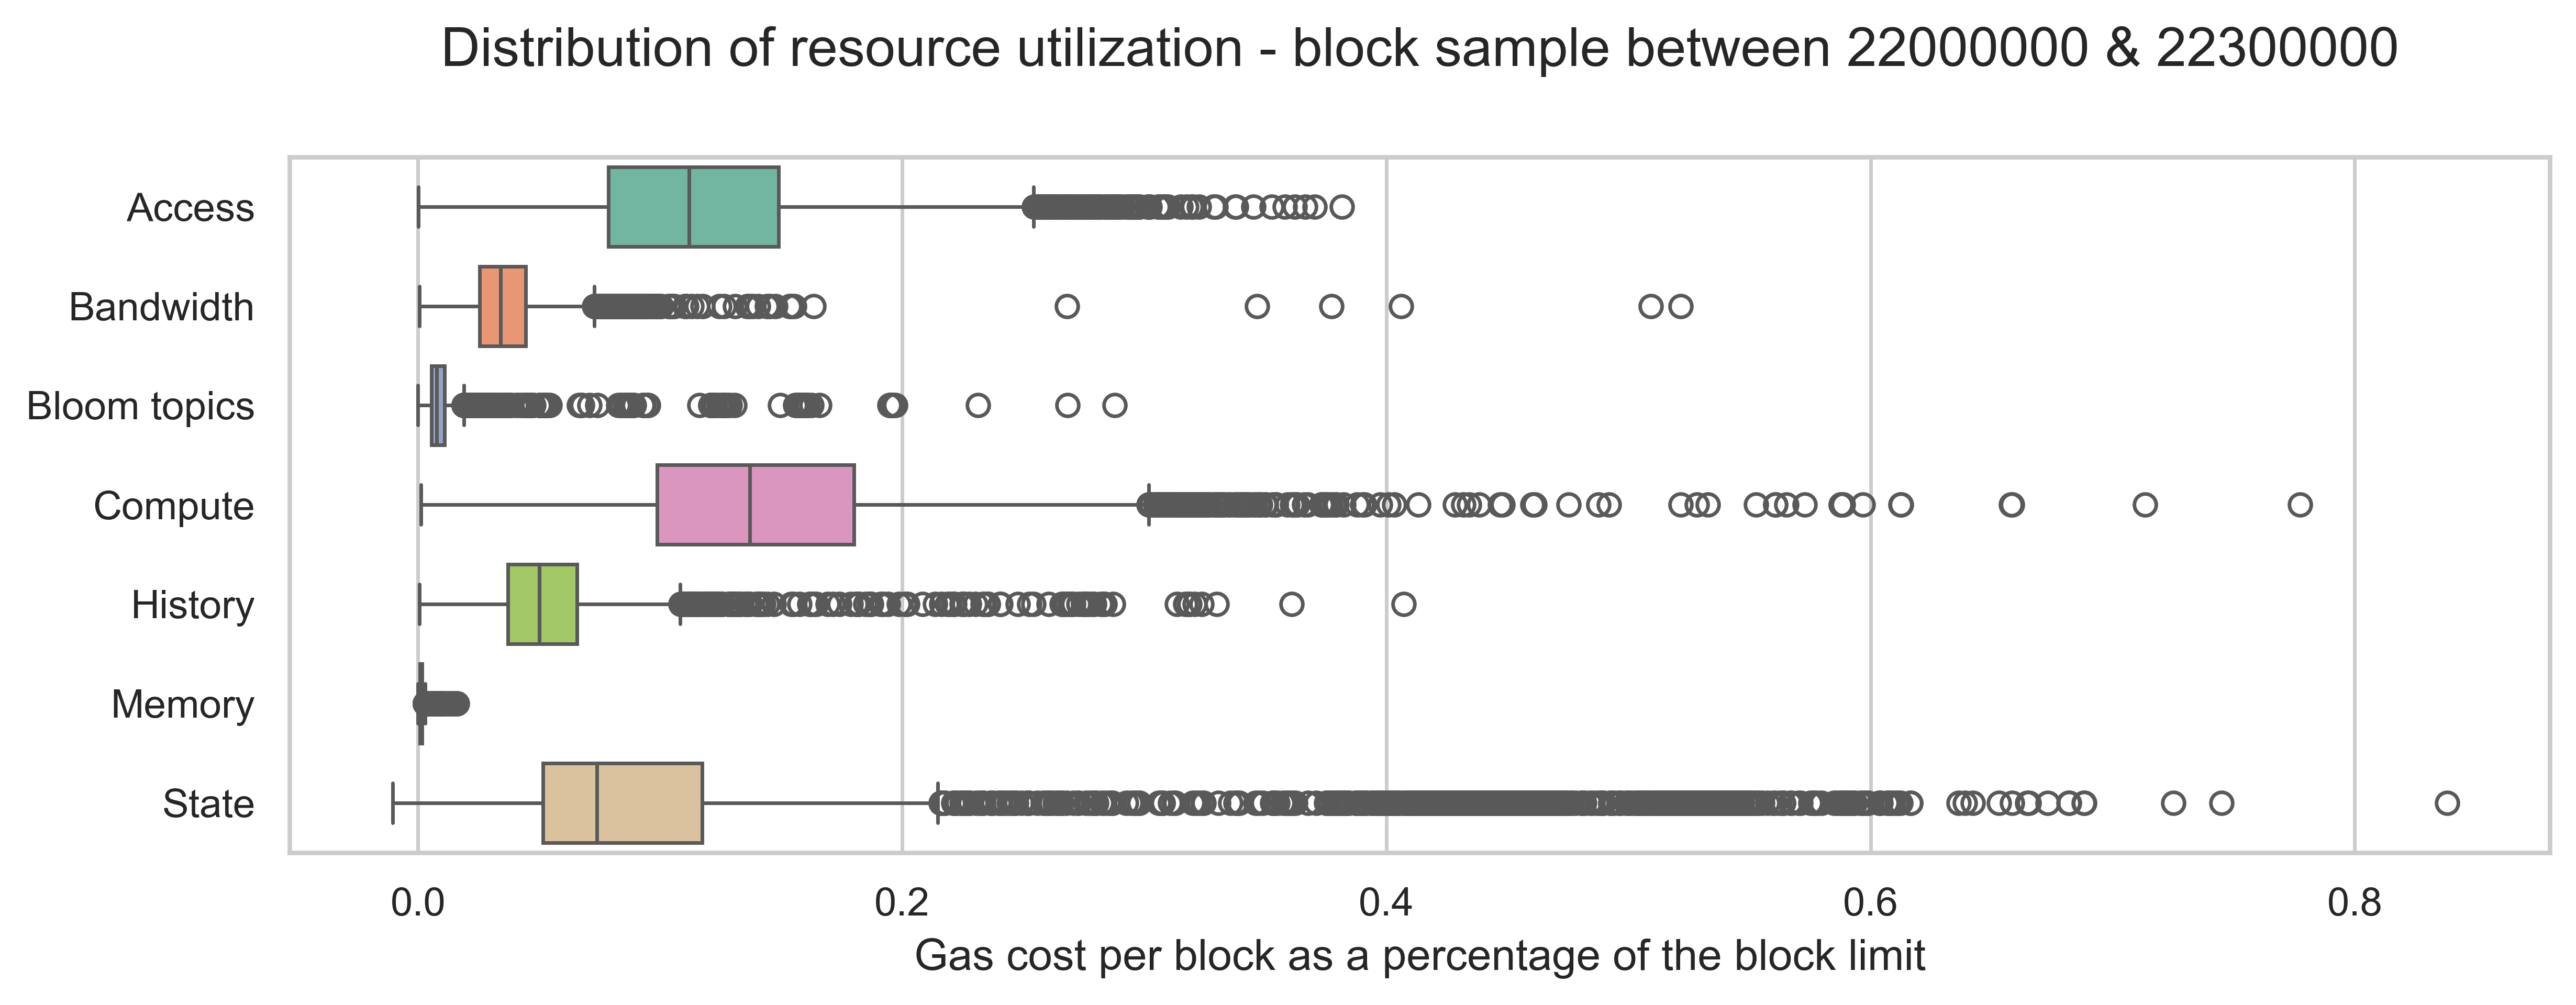

In [52]:
temp_df = (
    melt_gas_by_resource_df[
        ~melt_gas_by_resource_df["Resource"].isin(["Unassigned", "State (exc. Refunds)"])
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    .reset_index()
)
temp_df["gas_cost"] = temp_df["gas_cost"] / 36_000_000

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization - block sample between {block_start} & {block_end}",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

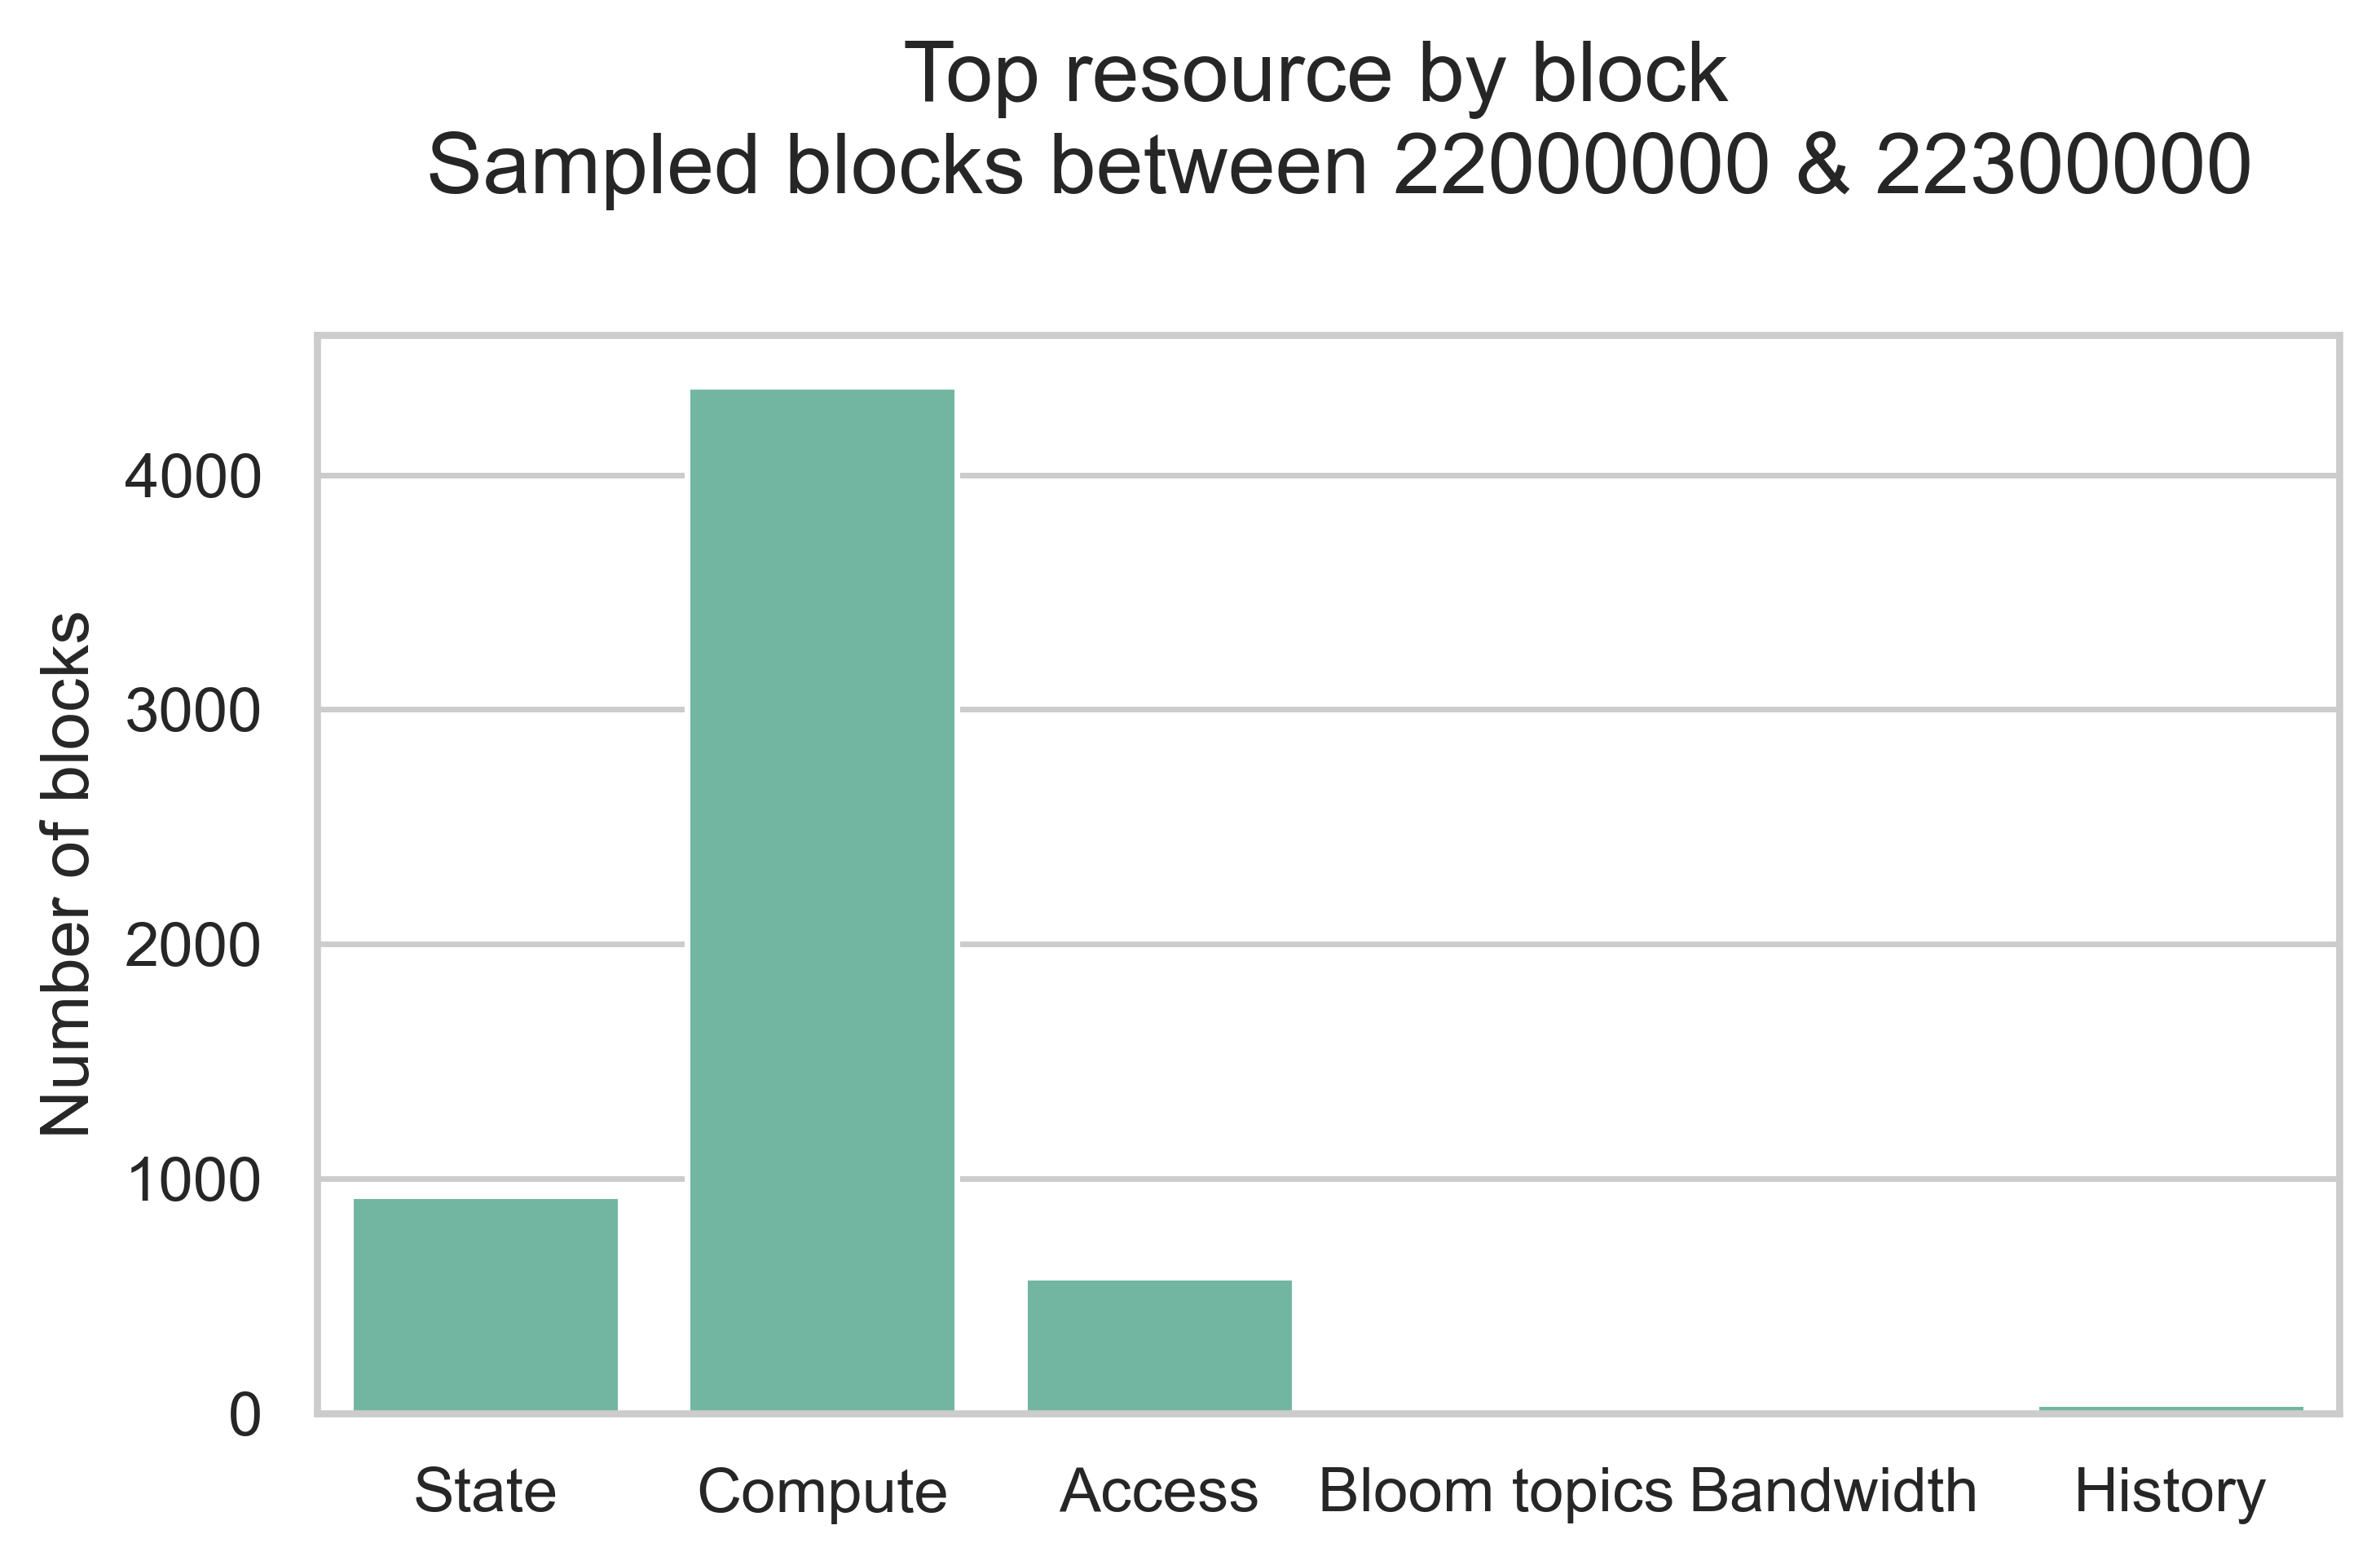

In [53]:
top_resource_df = (
    (totals_df / 36_000_000)
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(6, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Sampled blocks between {block_start} & {block_end}",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

In [54]:
top_resource_df.groupby("Resource").count()

,gas_cost
Resource,
Access,581
Bandwidth,12
Bloom topics,1
Compute,4378
History,42
State,927


## 7. High utilization blocks

In [55]:
resource_by_block_df = totals_df.copy()
resource_by_block_df["Total"] = resource_by_block_df.sum(axis=1)
resource_by_block_df = resource_by_block_df / 36_000_000

Tx %: 39.7576165628682


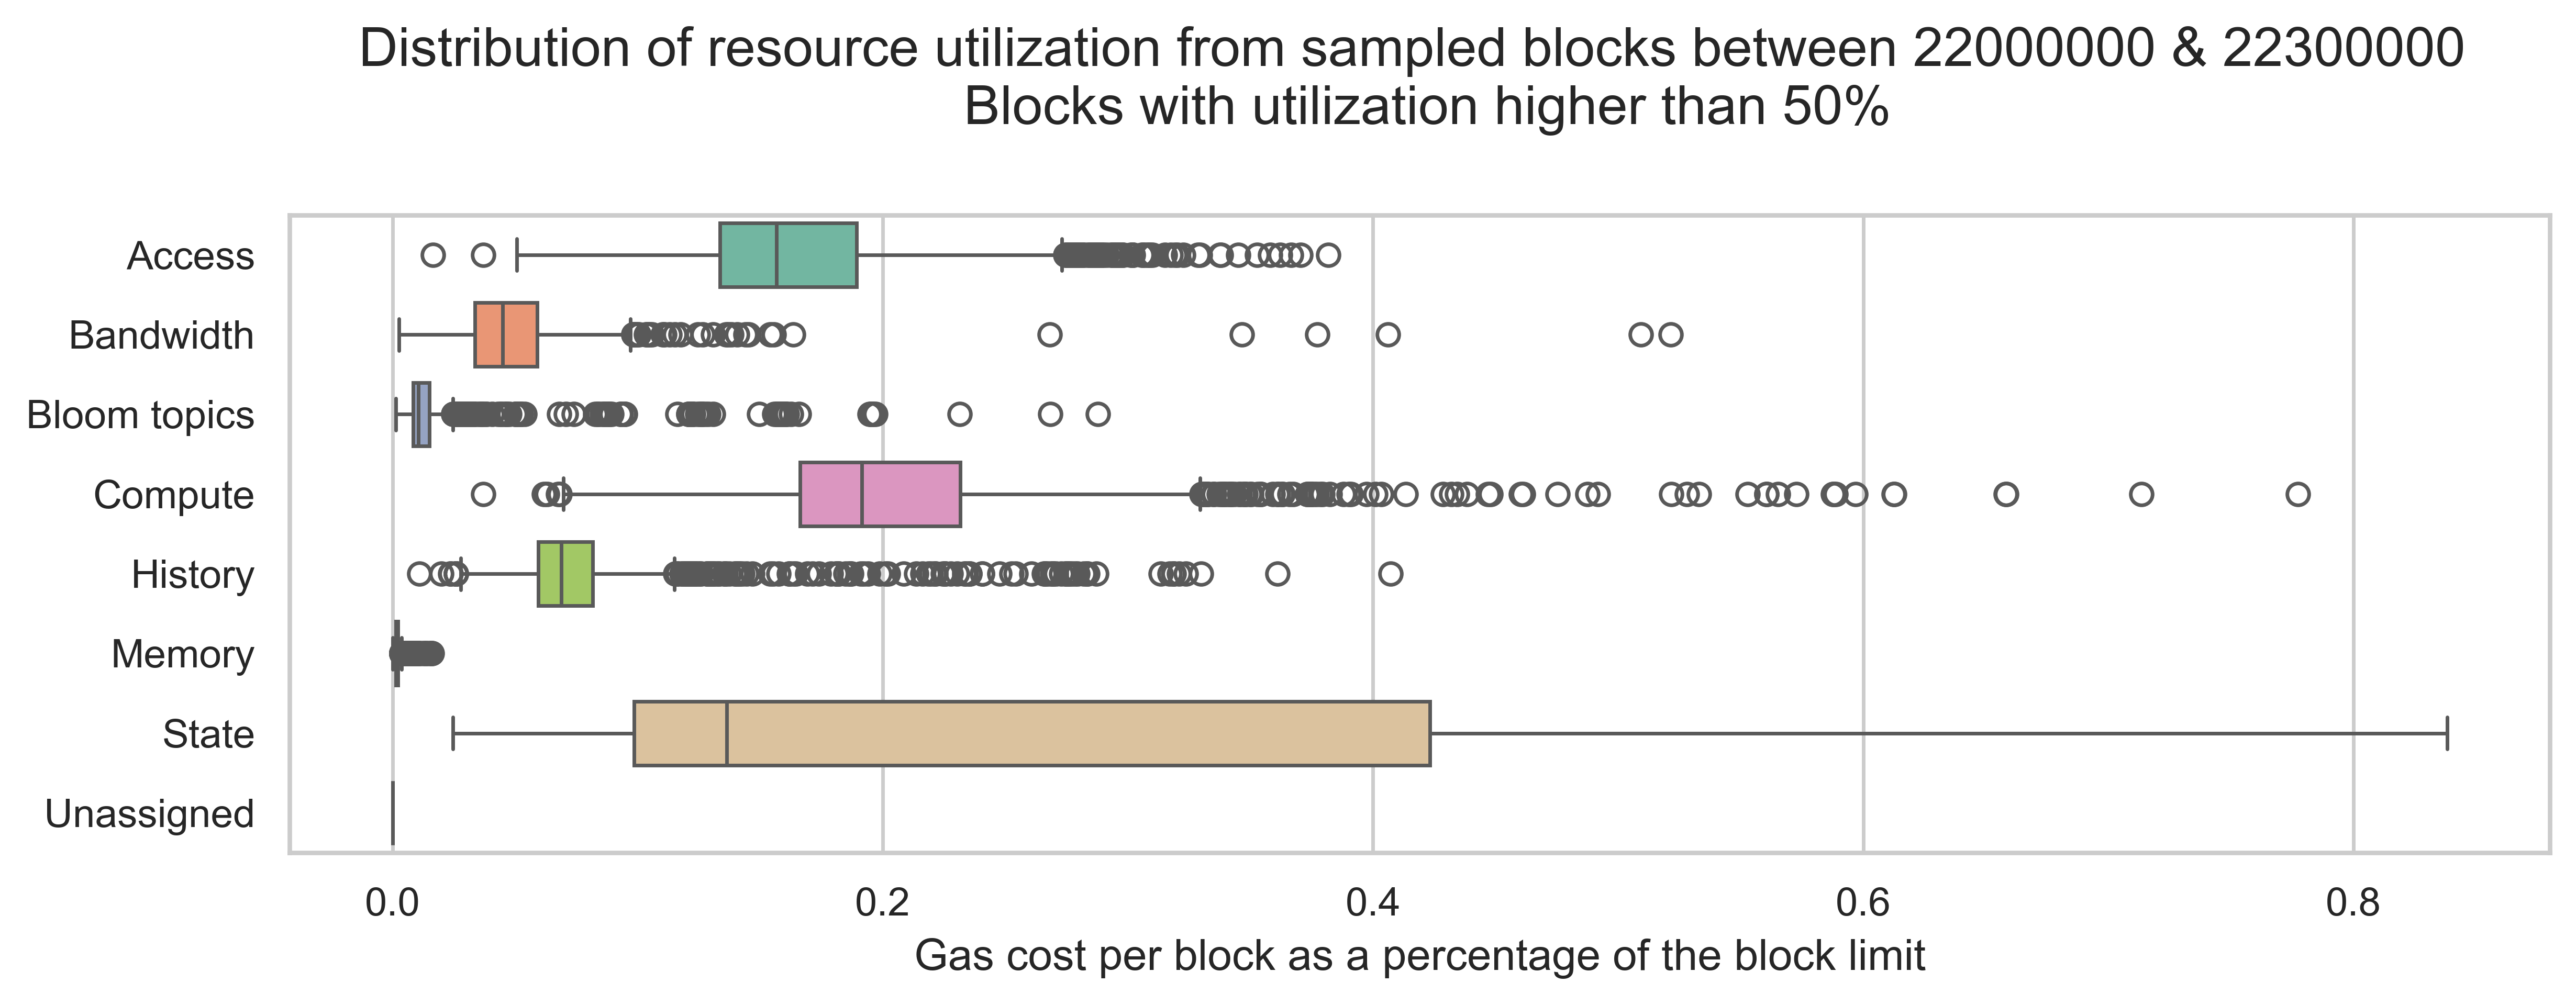

In [56]:
thres = 0.5
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from sampled blocks between {block_start} & {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

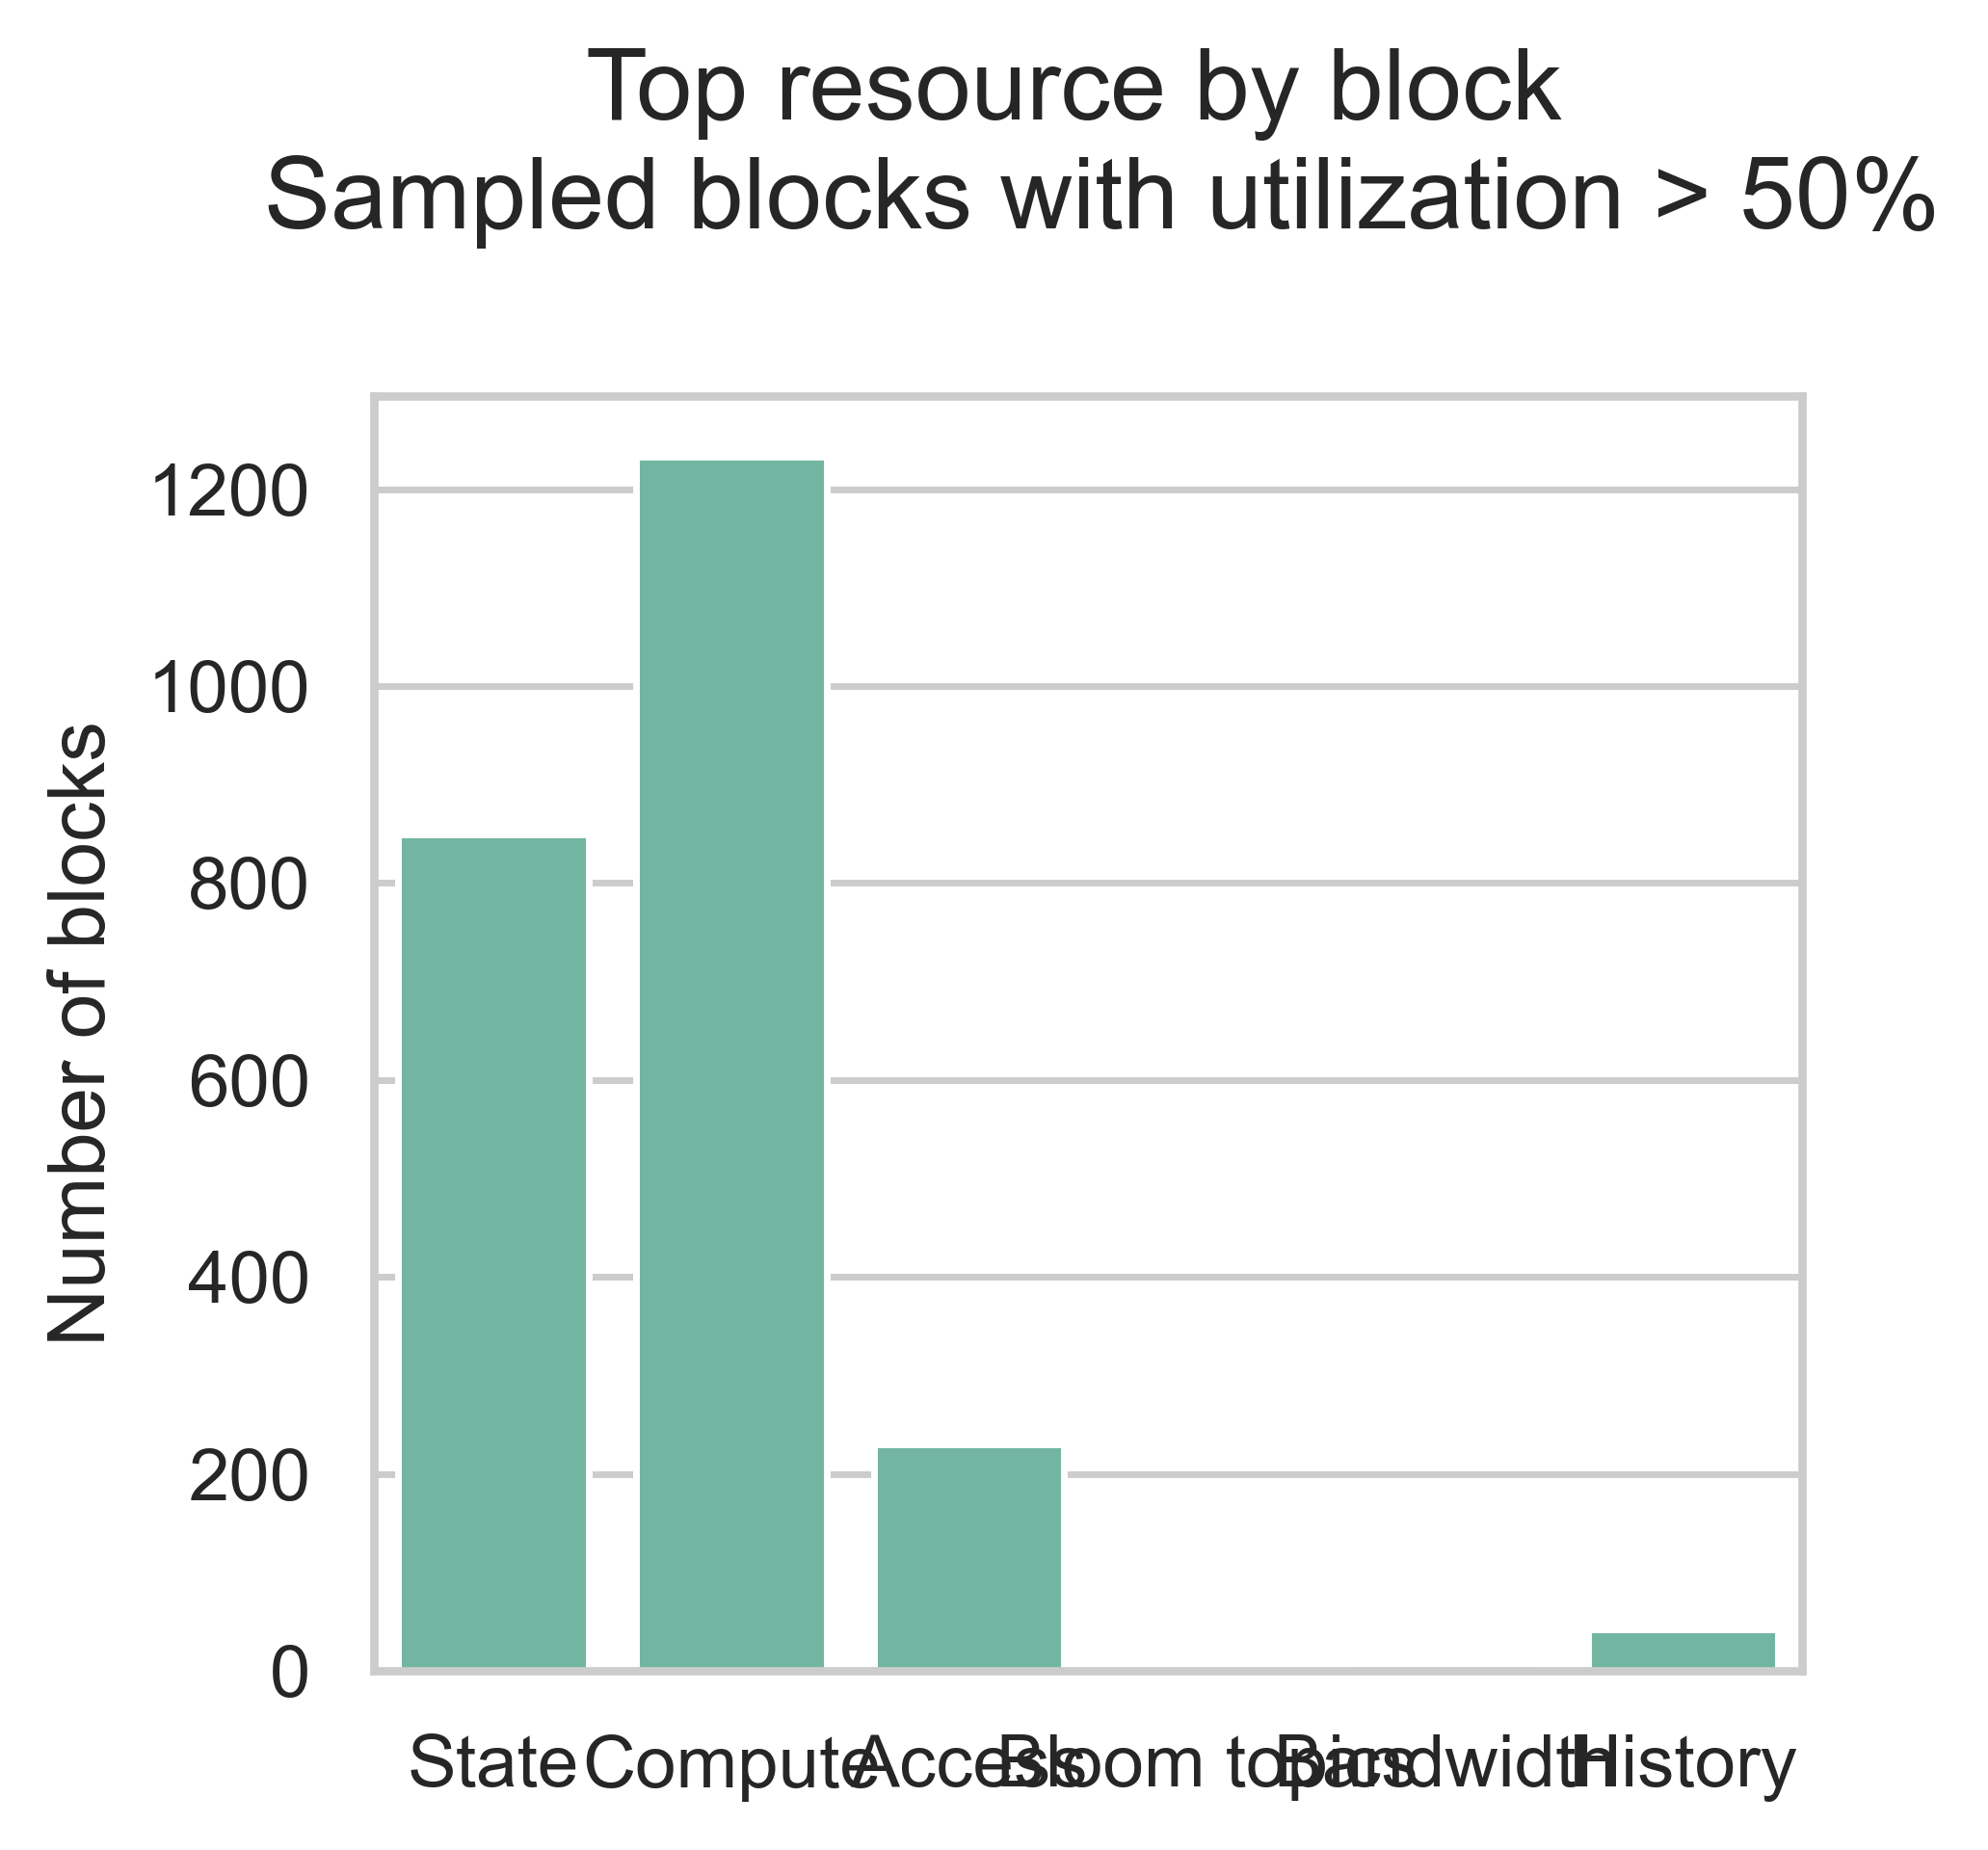

In [57]:
thres = 0.5
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Sampled blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 16.344049823262075


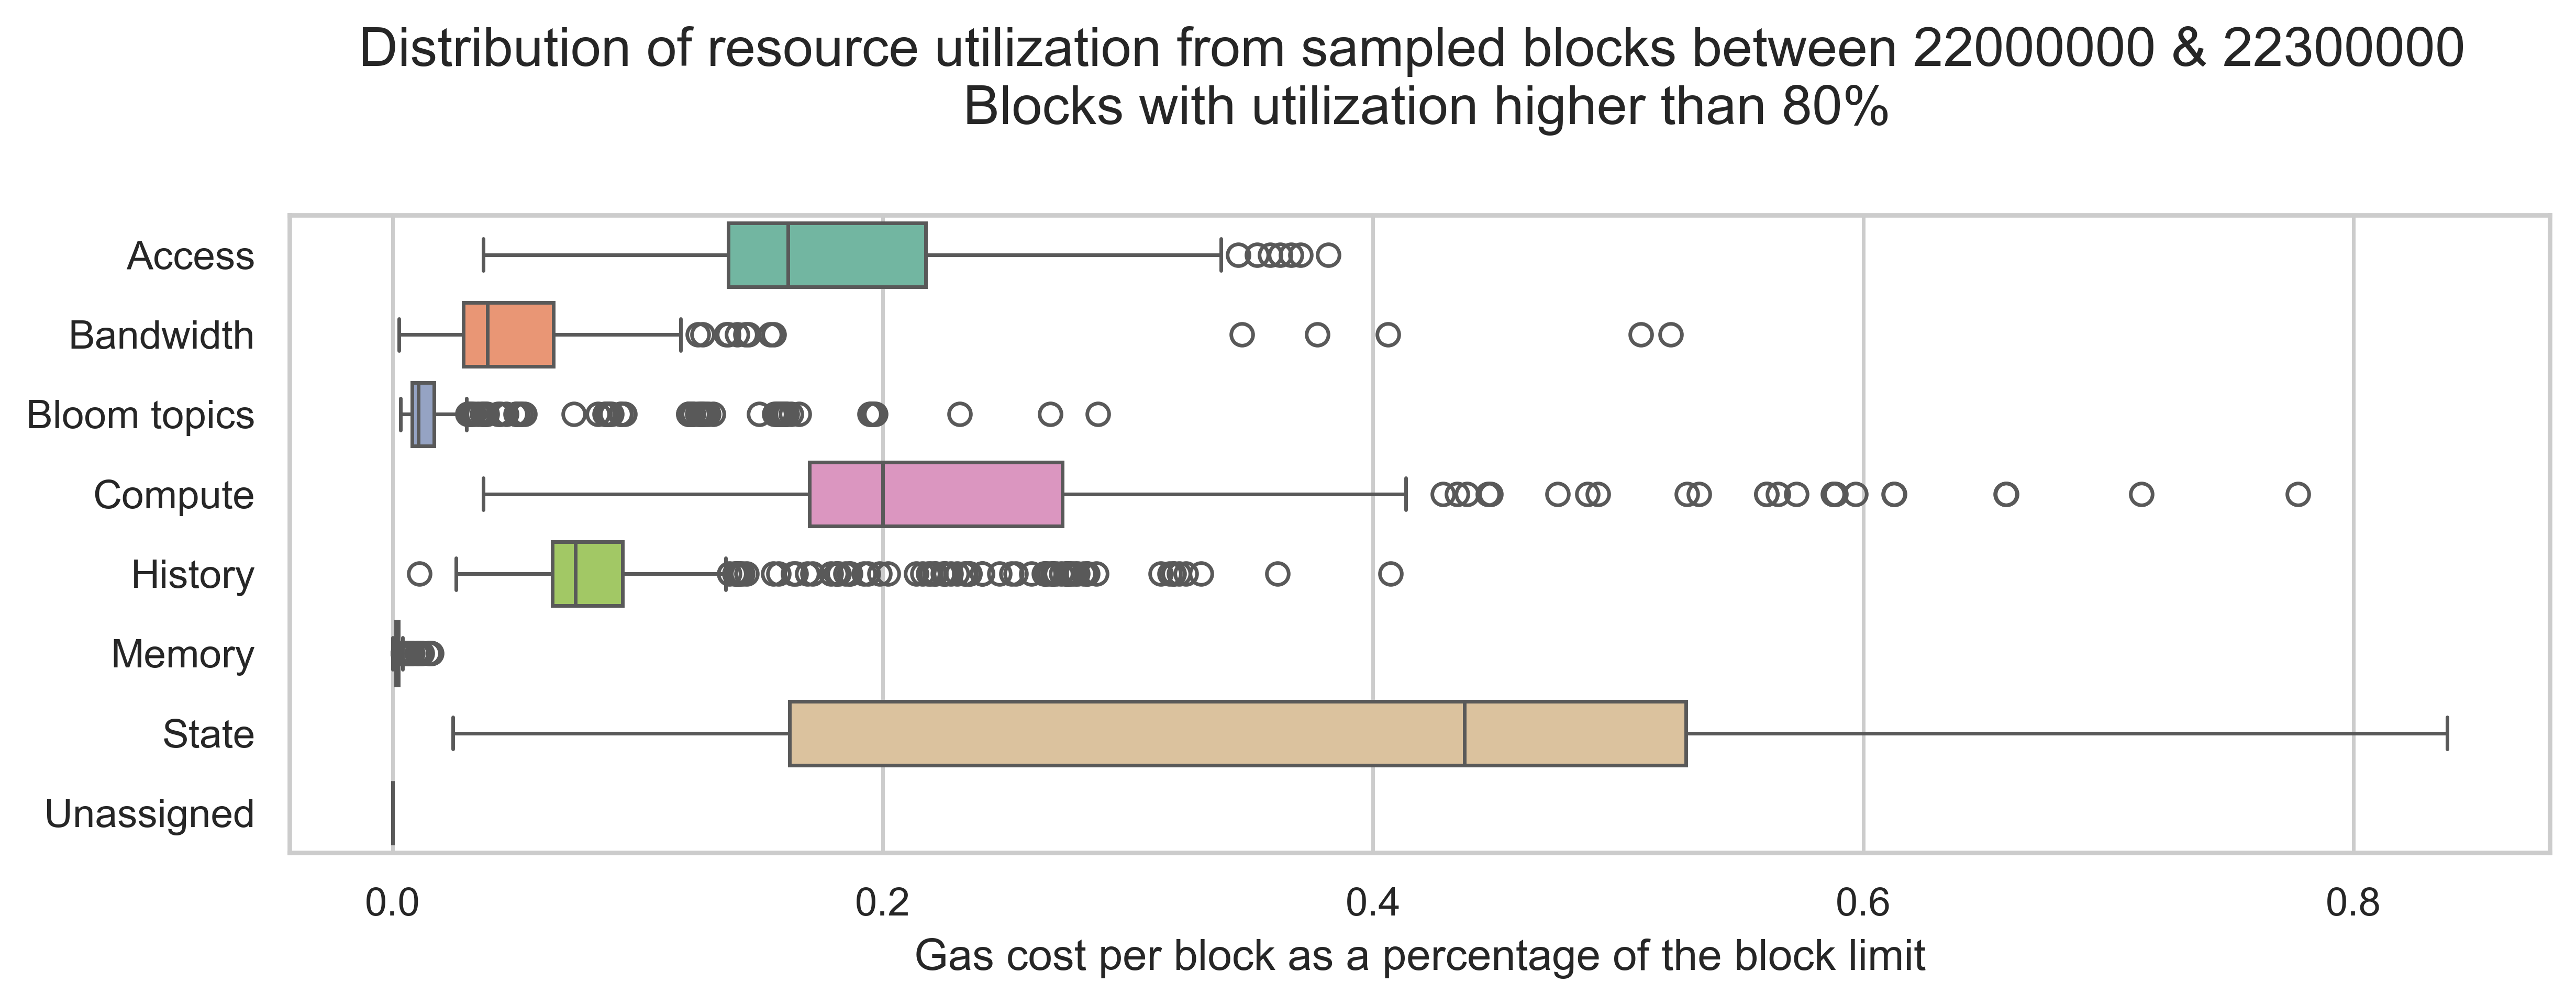

In [58]:
thres = 0.8
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from sampled blocks between {block_start} & {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

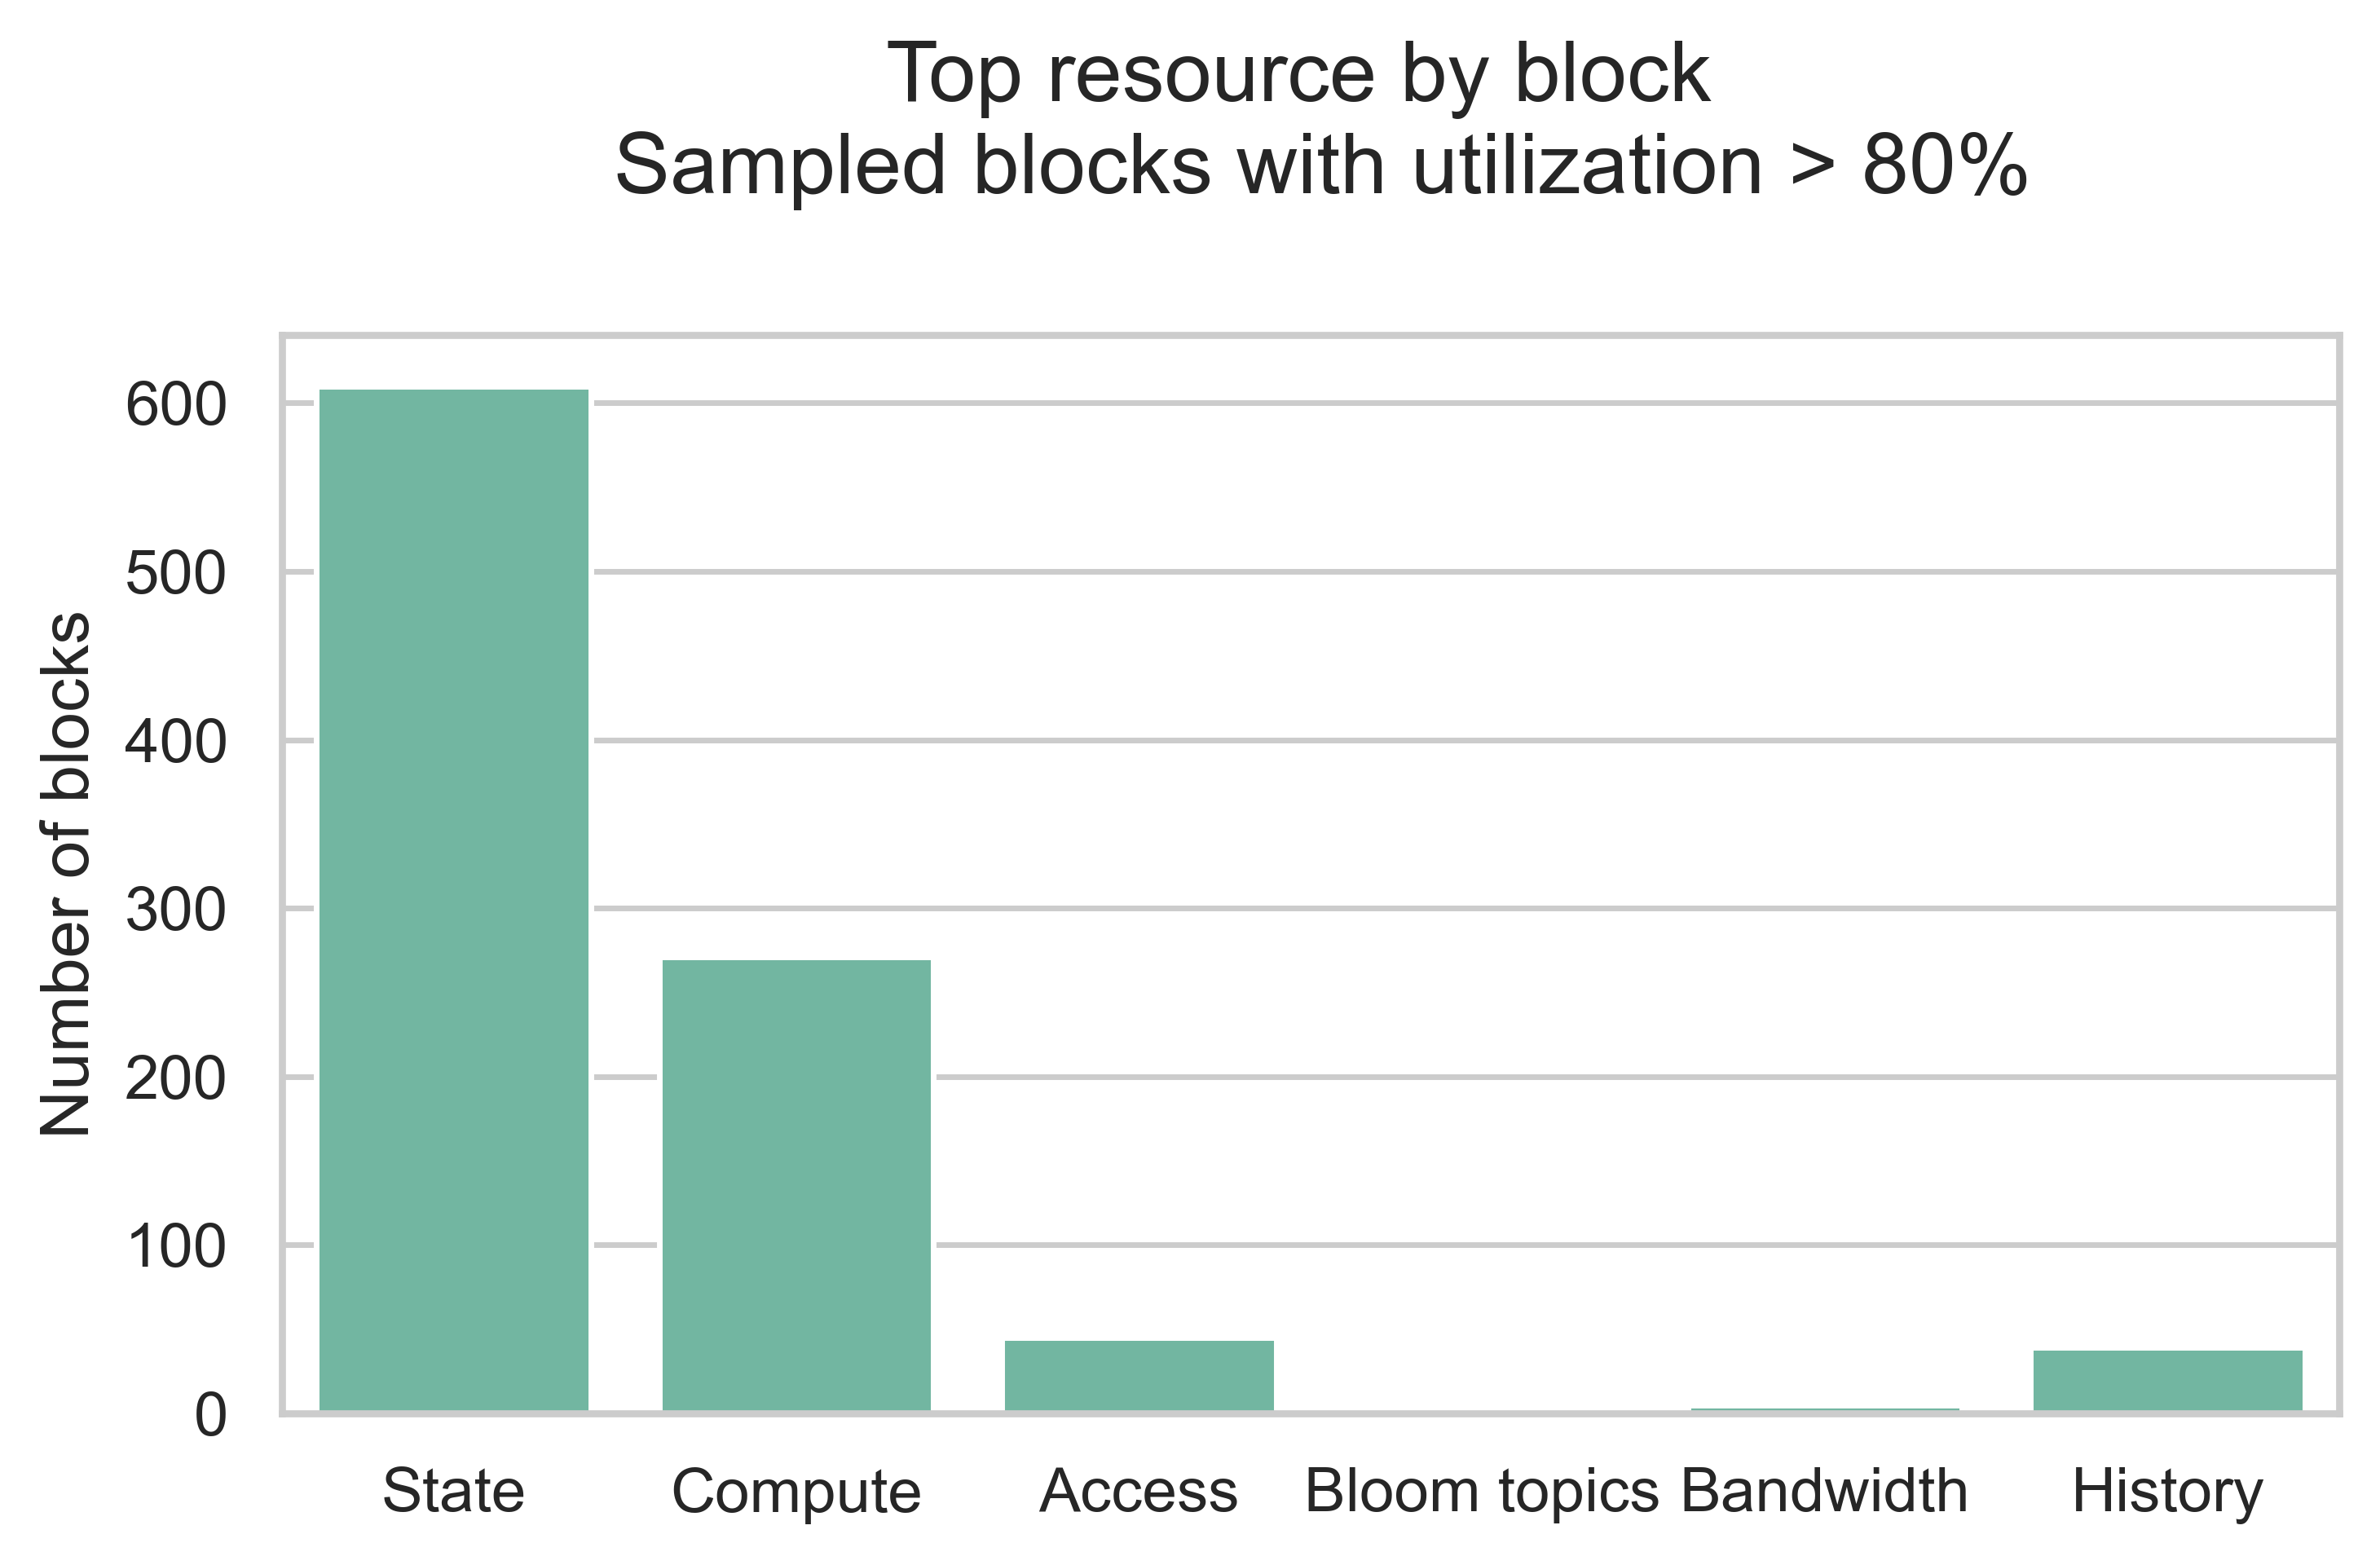

In [60]:
thres = 0.8
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(6, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Sampled blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 7.759636424844302


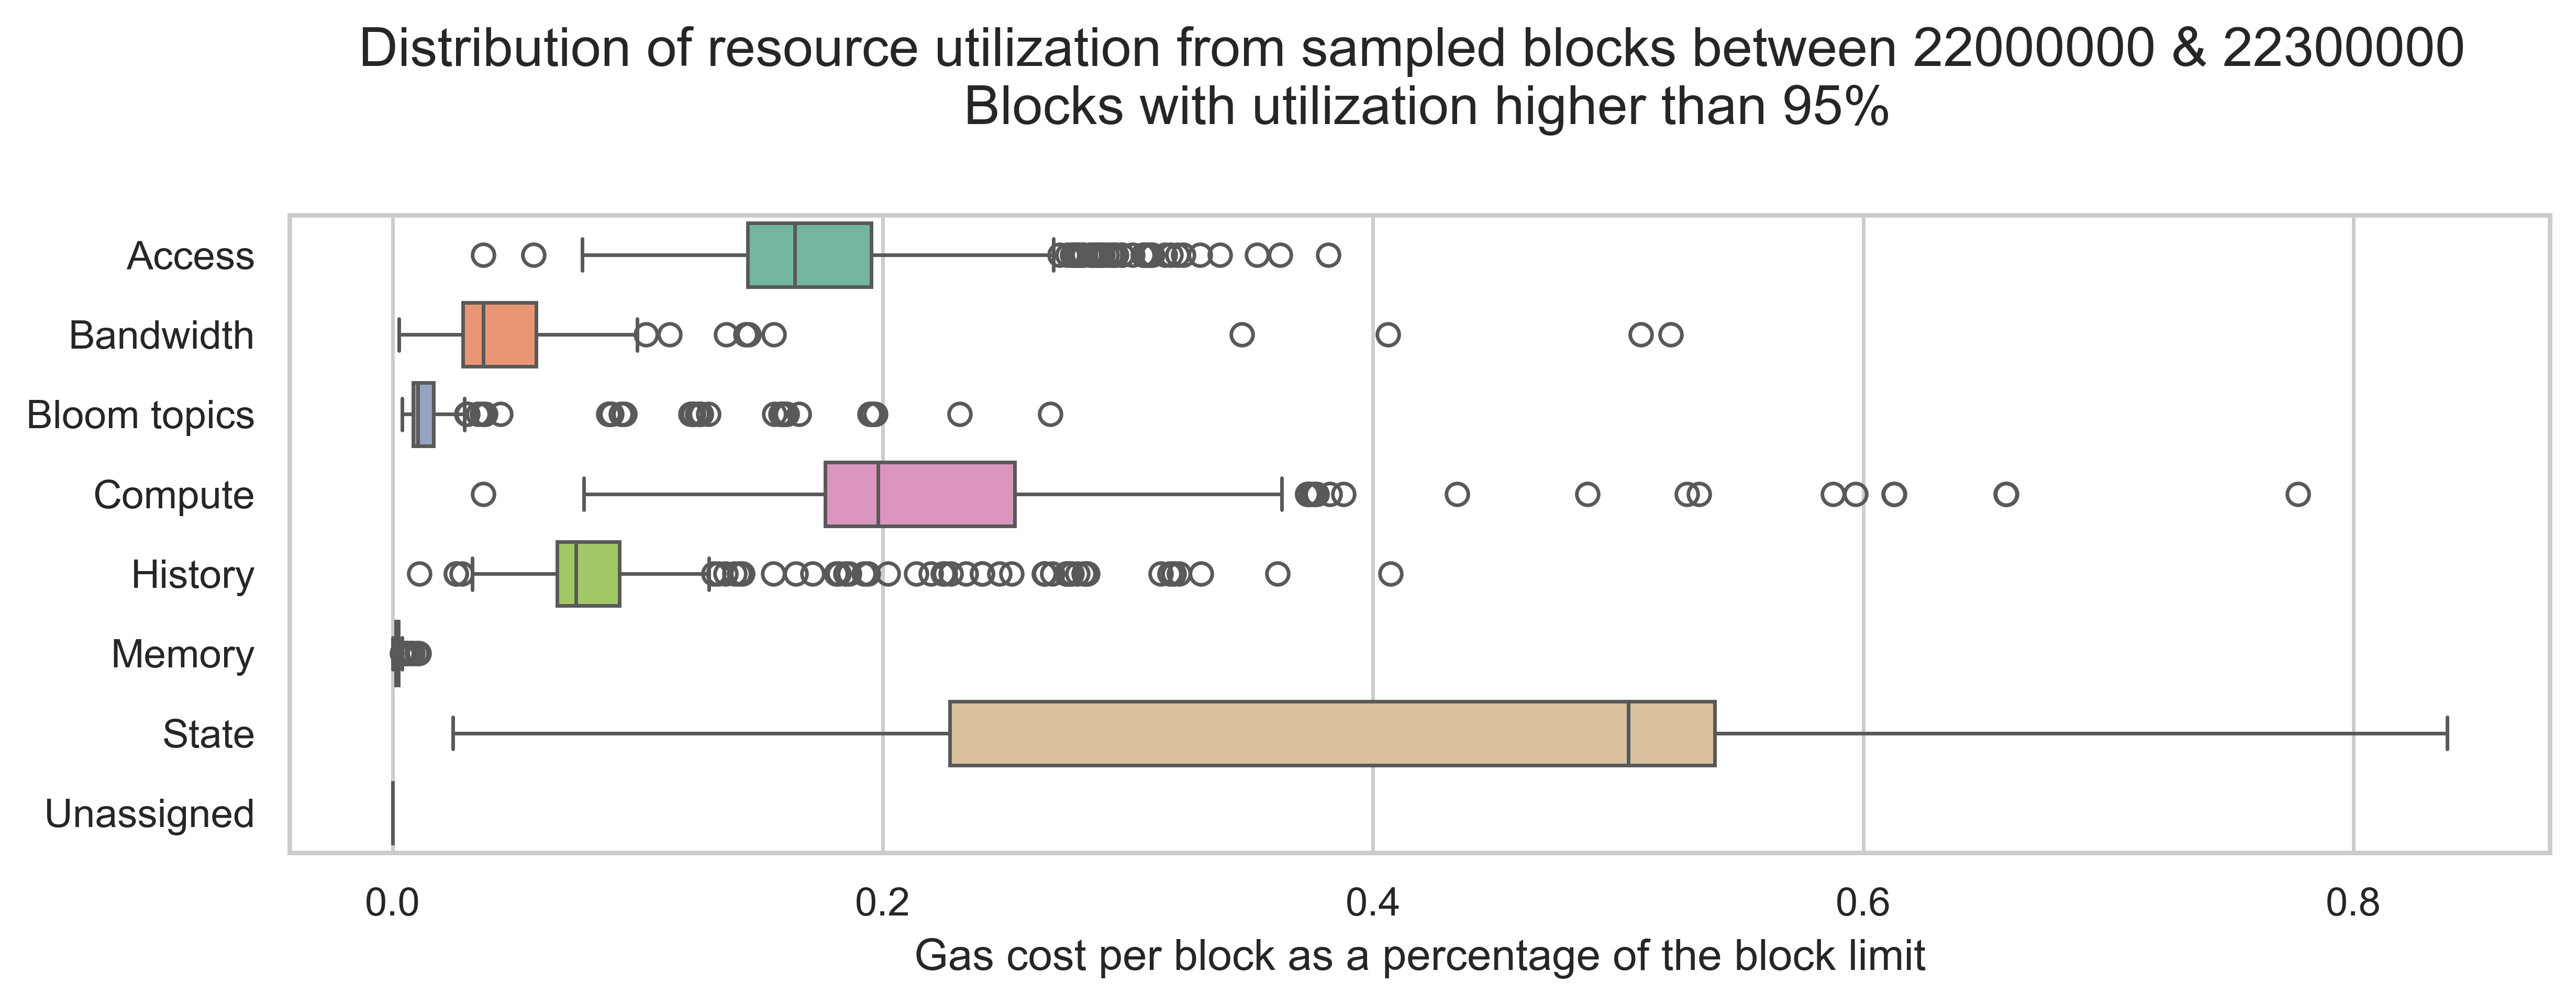

In [61]:
thres = 0.95
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from sampled blocks between {block_start} & {block_end} \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

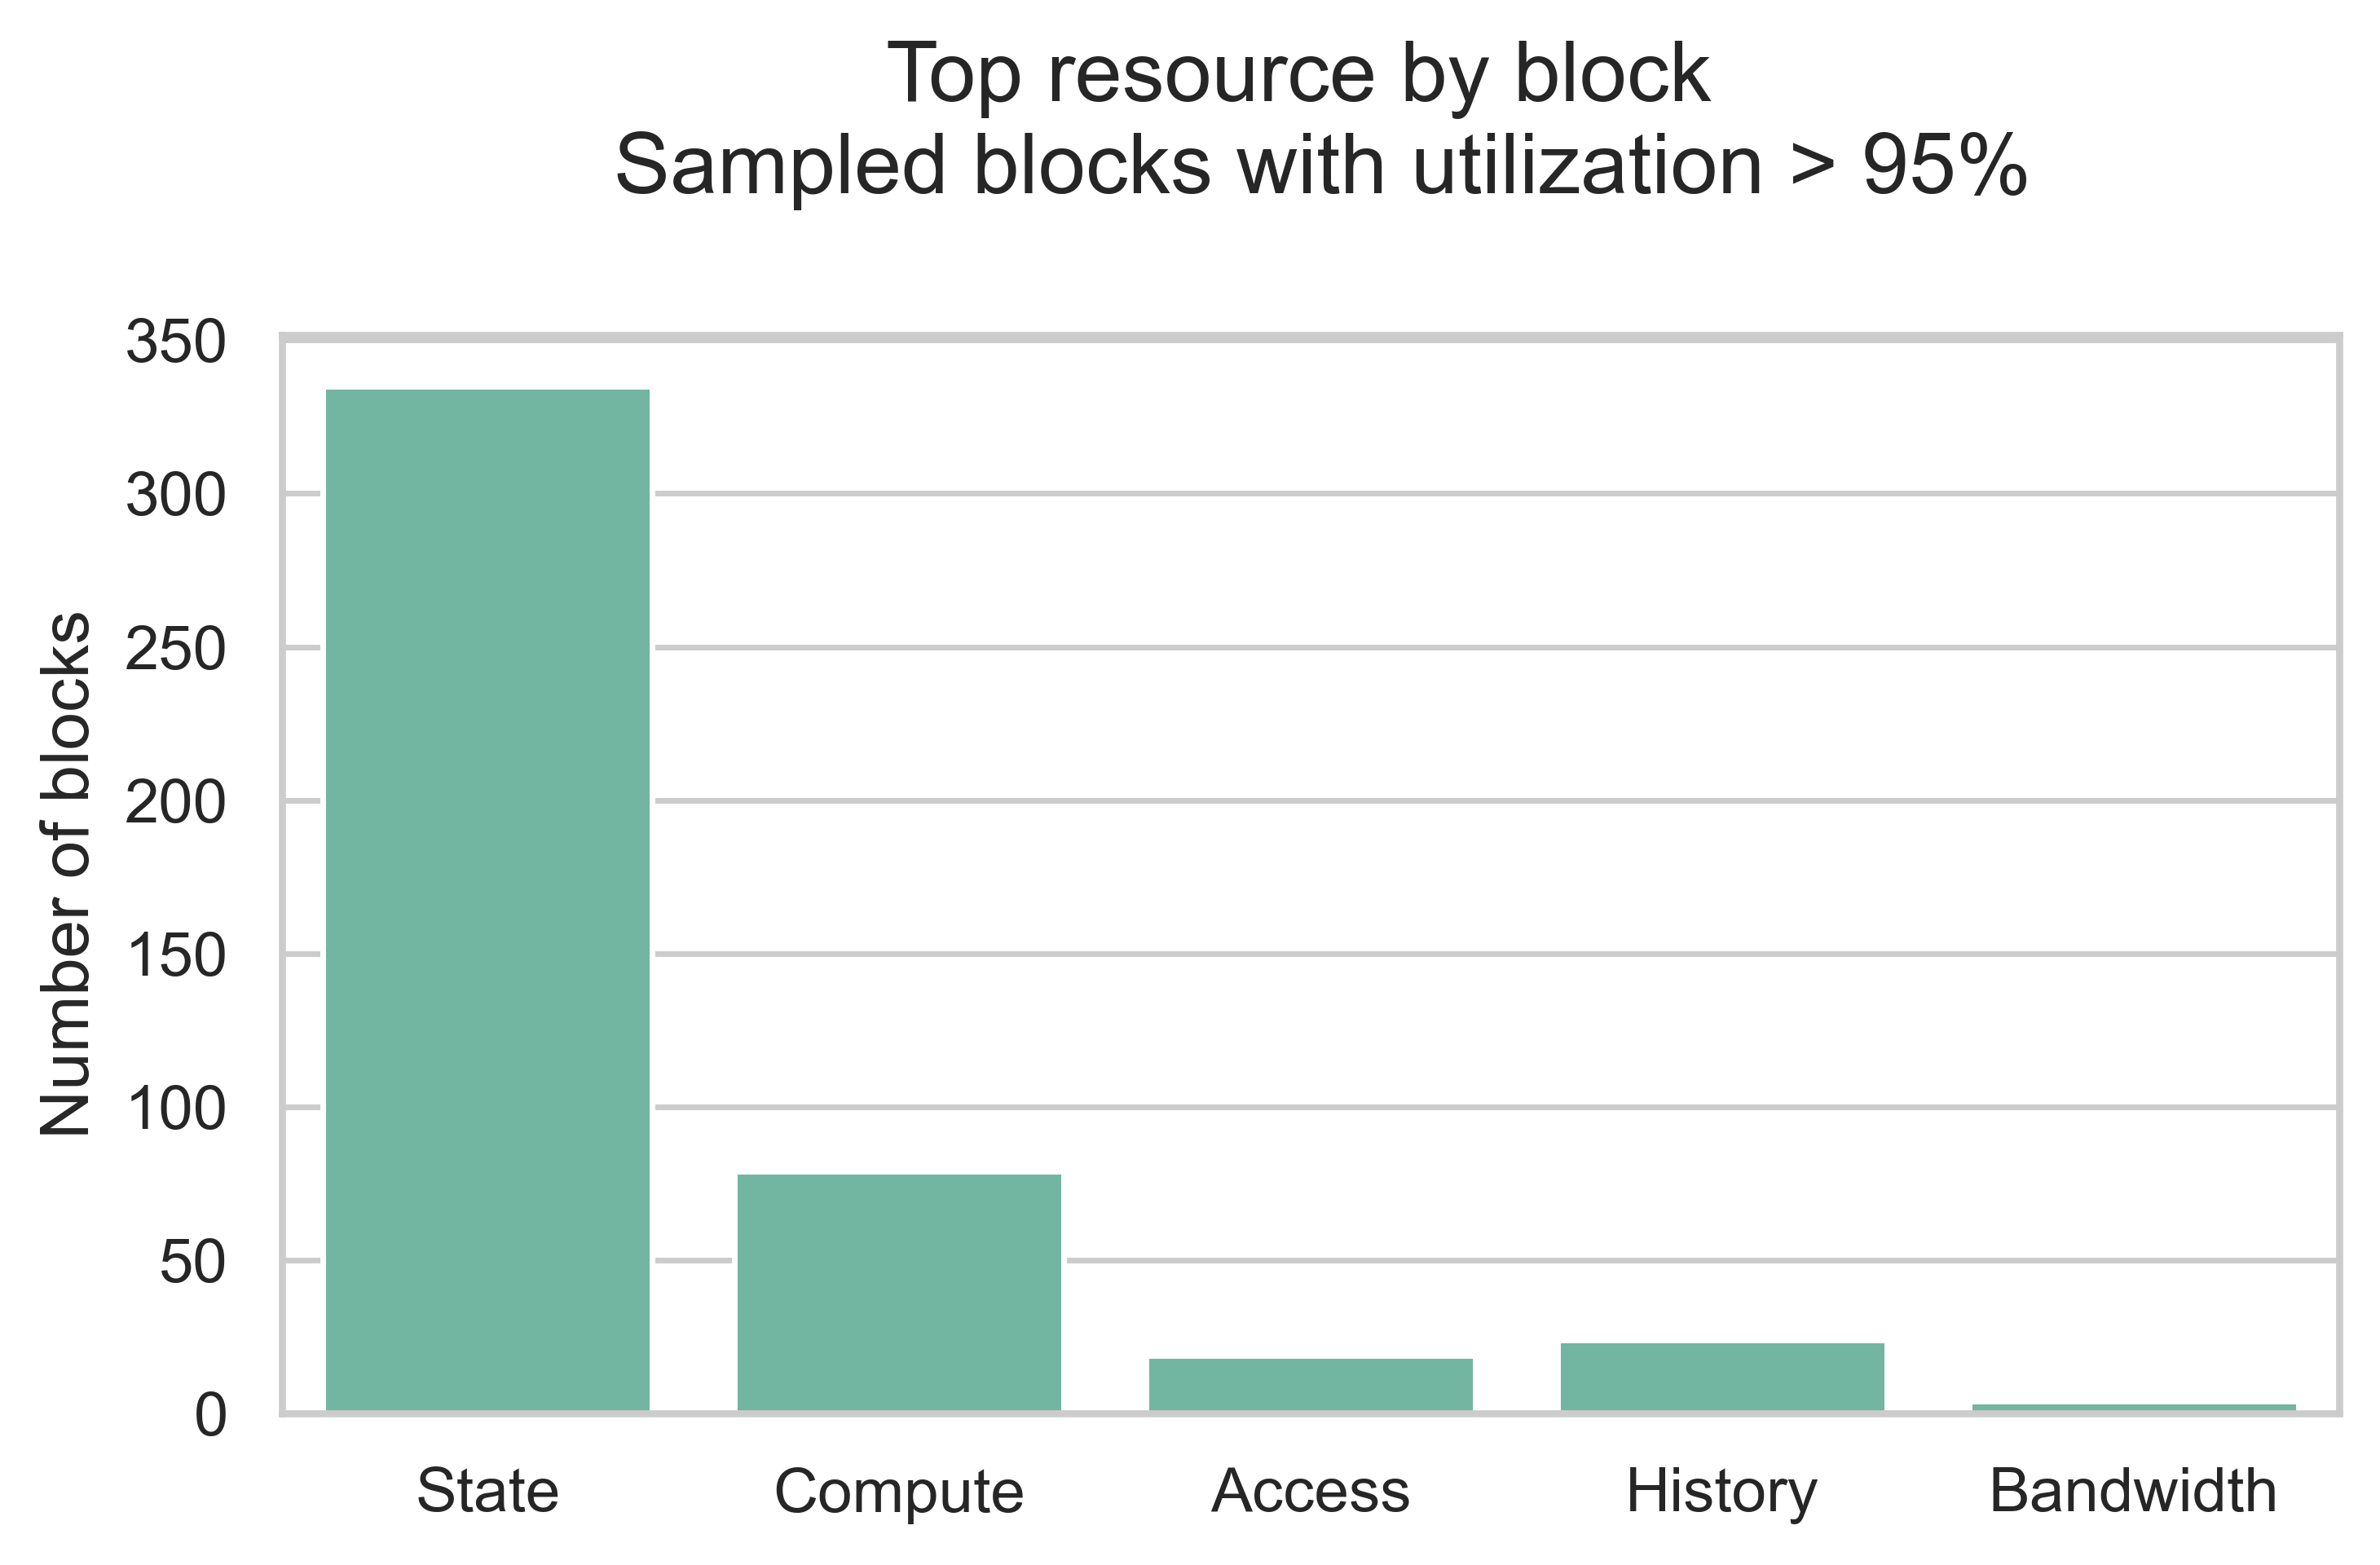

In [63]:
thres = 0.95
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(6, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Sampled blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

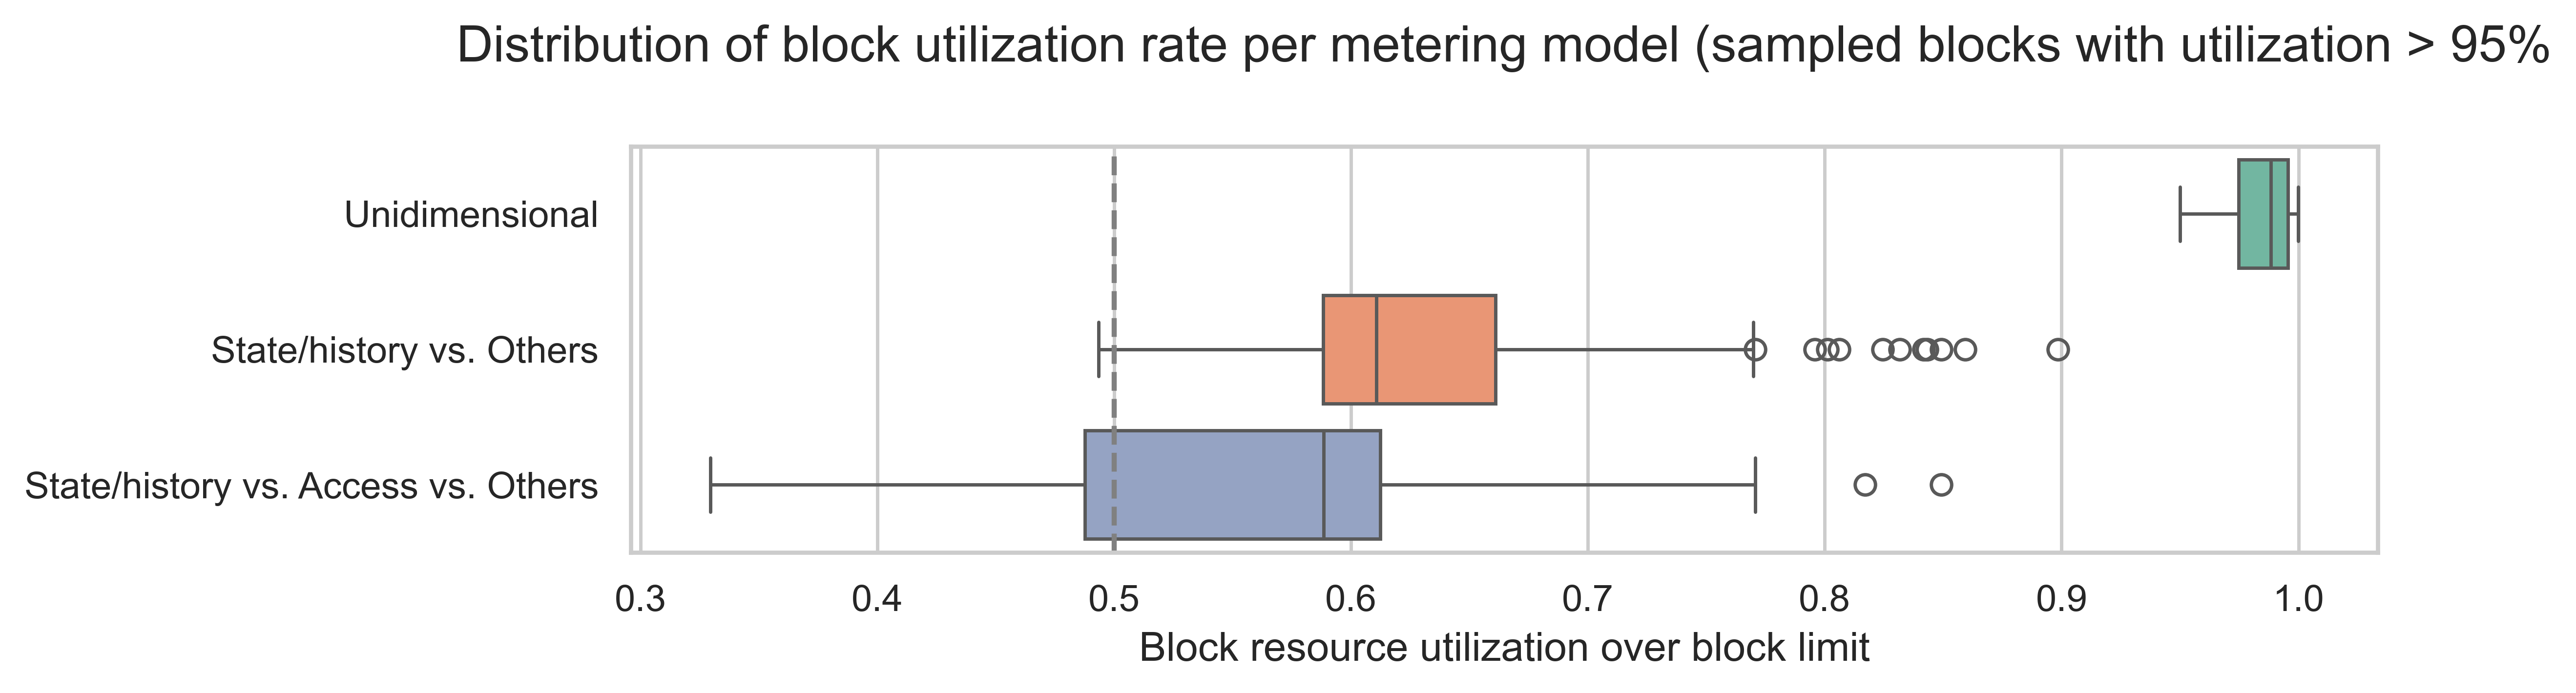

In [64]:
thres = 0.95
top_resource_blocks = resource_by_block_df[resource_by_block_df["Total"] > thres].index.values.tolist()

plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df[util_melt_df["block_height"].isin(top_resource_blocks)],
    x="perc_over_limit",
    y="meter",
    hue="meter",
    legend=False,
)
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title(
    f"Distribution of block utilization rate per metering model (sampled blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.tight_layout()
plt.show()